## This notebook required GPU and should be run within ChromBPNet docker environment

In [ ]:
### These environments are installed within docker: 
!pip install jupyterlab
!pip install pysam
!conda install -c bioconda pandas -y
!conda install -c bioconda logomaker -y 
!conda install -c bioconda seaborn -y 
!pip install hdf5plugin
!conda install conda-forge::numba

In [43]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pyfaidx
from collections import Counter, defaultdict, OrderedDict
import logomaker
from copy import deepcopy
from tqdm import tqdm
from tqdm import tnrange
import deepdish
import pyBigWig
import tqdm
import sys
import pyfaidx
sys.path.append("../../../chrombpnet/")
from training.utils.losses import multinomial_nll
from training.utils.one_hot import dna_to_one_hot
from evaluation.interpret.shap_utils import *
import pickle
import shap
import glob
tf.compat.v1.disable_eager_execution()
import scipy.stats
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import pyBigWig
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
import sys
sys.path.append("../../../src/")
custom_objects={"tf":tf, "multinomial_nll":multinomial_nll}    
get_custom_objects().update(custom_objects)
from tensorflow import keras
from numba import njit, prange
import math

In [44]:
lst_keys =[]
lst_values = []
with open('./motif_clustering_data/all_motif_clusters.annot.meme', 'r') as f:
    for l in f.readlines():
            if l.startswith("MOTIF"):
                l = l.split()[-1].split(' ')[0]
                lst_values.append(l)
                l = l.split()[-1].split('|')[0]
                lst_keys.append(l)

res = {lst_keys[i]: lst_values[i] for i in range(len(lst_keys))}


In [45]:
def generate_shap_dict(seqs, scores):
    print(seqs.shape, scores.shape)
    assert(seqs.shape==scores.shape)
    assert(seqs.shape[2]==4)

    # construct a dictionary for the raw shap scores and the
    # the projected shap scores
    # MODISCO workflow expects one hot sequences with shape (None,4,inputlen)
    d = {
            'raw': {'seq': np.transpose(seqs, (0, 2, 1))},
            'shap': {'seq': np.transpose(scores, (0, 2, 1))},
            'projected_shap': {'seq': np.transpose(seqs*scores, (0, 2, 1))}
        }

    return d

In [46]:
from deeplift.dinuc_shuffle import dinuc_shuffle

def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    
    for l in [0]:
        projected_hypothetical_contribs = \
            np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        
        # At each position in the input sequence, we iterate over the
        # one-hot encoding possibilities (eg: for genomic sequence, 
        # this is ACGT i.e. 1000, 0100, 0010 and 0001) and compute the
        # hypothetical difference-from-reference in each case. We then 
        # multiply the hypothetical differences-from-reference with 
        # the multipliers to get the hypothetical contributions. For 
        # each of the one-hot encoding possibilities, the hypothetical
        # contributions are then summed across the ACGT axis to 
        # estimate the total hypothetical contribution of each 
        # position. This per-position hypothetical contribution is then
        # assigned ("projected") onto whichever base was present in the
        # hypothetical sequence. The reason this is a fast estimate of
        # what the importance scores *would* look like if different 
        # bases were present in the underlying sequence is that the
        # multipliers are computed once using the original sequence, 
        # and are not computed again for each hypothetical sequence.
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:, i] = 1.0
            hypothetical_difference_from_reference = \
                (hypothetical_input[None, :, :] - bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference * \
                                    mult[l]
            projected_hypothetical_contribs[:, :, i] = \
                np.sum(hypothetical_contribs, axis=-1) 
            
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))

    if len(orig_inp)>1:
        to_return.append(np.zeros_like(orig_inp[1]))
    
    return to_return


def shuffle_several_times(s):
    numshuffles=20
    if len(s)==2:
        return [np.array([dinuc_shuffle(s[0]) for i in range(numshuffles)]),
                np.array([s[1] for i in range(numshuffles)])]
    else:
        return [np.array([dinuc_shuffle(s[0]) for i in range(numshuffles)])]

In [47]:
def get_weightedsum_meannormed_logits(model):
    # Assumes the 0 task track is for profile
    # See Google slide deck for explanations
    # We meannorm as per section titled 
    # "Adjustments for Softmax Layers" in the DeepLIFT paper
    meannormed_logits = (model.outputs[0] - \
                         tf.reduce_mean(model.outputs[0], axis=1)[:, None])

    # 'stop_gradient' will prevent importance from being propagated
    # through this operation; we do this because we just want to treat
    # the post-softmax probabilities as 'weights' on the different 
    # logits, without having the network explain how the probabilities
    # themselves were derived. Could be worth contrasting explanations
    # derived with and without stop_gradient enabled...
    stopgrad_meannormed_logits = tf.stop_gradient(meannormed_logits)
    softmax_out = tf.nn.softmax(stopgrad_meannormed_logits, axis=1)
    
    # Weight the logits according to the softmax probabilities, take
    # the sum for each example. This mirrors what was done for the
    # bpnet paper.
    weightedsum_meannormed_logits = tf.reduce_sum(softmax_out * \
                                                  meannormed_logits,
                                                  axis=1)
    
    return weightedsum_meannormed_logits

In [48]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def ic_scale(pwm,background):
    odds_ratio = ((pwm+0.001)/(1.004))/(background[None,:])
    ic = ((np.log((pwm+0.001)/(1.004))/np.log(2))*pwm -\
            (np.log(background)*background/np.log(2))[None,:])
    return pwm*(np.sum(ic,axis=1)[:,None])


def plot_a(ax, base, left_edge, height, color):
    a_polygon_coords = [
        np.array([
           [0.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.2, 0.0],
        ]),
        np.array([
           [1.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.8, 0.0],
        ]),
        np.array([
           [0.225, 0.45],
           [0.775, 0.45],
           [0.85, 0.3],
           [0.15, 0.3],
        ])
    ]
    for polygon_coords in a_polygon_coords:
        ax.add_patch(matplotlib.patches.Polygon((np.array([1,height])[None,:]*polygon_coords
                                                 + np.array([left_edge,base])[None,:]),
                                                facecolor=color, edgecolor=color))


def plot_c(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))


def plot_g(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.825, base+0.085*height], width=0.174, height=0.415*height,
                                            facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.625, base+0.35*height], width=0.374, height=0.15*height,
                                            facecolor=color, edgecolor=color, fill=True))


def plot_t(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.4, base],
                  width=0.2, height=height, facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge, base+0.8*height],
                  width=1.0, height=0.2*height, facecolor=color, edgecolor=color, fill=True))

default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
default_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}
def plot_weights_given_ax(ax, array,
                 height_padding_factor,
                 length_padding,
                 subticks_frequency,
                 highlight,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 ylabel="",
                 ylim=None):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        #sort from smallest to highest magnitude
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if (letter[1] > 0):
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            else:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            plot_func(ax=ax, base=height_so_far, left_edge=i, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)

    #now highlight any desired positions; the key of
    #the highlight dict should be the color
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                matplotlib.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
            
    ax.set_xlim(-length_padding, array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(0.0, array.shape[0]+1, subticks_frequency))

    if ylim is not None:
        # Use user-specified y-axis limits
        min_neg_height, max_pos_height = ylim
        assert min_neg_height <= 0
        assert max_pos_height >= 0

    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    ax.set_ylabel(ylabel)
    ax.yaxis.label.set_fontsize(15)


def plot_weights(array,
                 figsize=(20,2),
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency=1.0,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 highlight={},
                 ylabel="",
                 ylim=None,
                 return_fig=False):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    plot_weights_given_ax(ax=ax, array=array,
        height_padding_factor=height_padding_factor,
        length_padding=length_padding,
        subticks_frequency=subticks_frequency,
        colors=colors,
        plot_funcs=plot_funcs,
        highlight=highlight,
        ylabel=ylabel,
        ylim=ylim)
    plt.ylim(ylim)
    #plt.savefig(filename,format="svg")

    if return_fig:
        return fig
    plt.show()

In [49]:
def dna_to_one_hot(seqs):
    """
    Converts a list of DNA ("ACGT") sequences to one-hot encodings, where the
    position of 1s is ordered alphabetically by "ACGT". `seqs` must be a list
    of N strings, where every string is the same length L. Returns an N x L x 4
    NumPy array of one-hot encodings, in the same order as the input sequences.
    All bases will be converted to upper-case prior to performing the encoding.
    Any bases that are not "ACGT" will be given an encoding of all 0s.
    """
    seq_len = len(seqs[0])
    assert np.all(np.array([len(s) for s in seqs]) == seq_len)

    # Join all sequences together into one long string, all uppercase
    seq_concat = "".join(seqs).upper() + "ACGT"
    # Add one example of each base, so np.unique doesn't miss indices later

    one_hot_map = np.identity(5)[:, :-1].astype(np.int8)

    # Convert string into array of ASCII character codes;
    base_vals = np.frombuffer(bytearray(seq_concat, "utf8"), dtype=np.int8)

    # Anything that's not an A, C, G, or T gets assigned a higher code
    base_vals[~np.isin(base_vals, np.array([65, 67, 71, 84]))] = 85

    # Convert the codes into indices in [0, 4], in ascending order by code
    _, base_inds = np.unique(base_vals, return_inverse=True)

    # Get the one-hot encoding for those indices, and reshape back to separate
    return one_hot_map[base_inds[:-4]].reshape((len(seqs), seq_len, 4))

In [50]:
def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

In [51]:
def min_max_norm(column):
    min_val = column.min()
    max_val = column.max()
    result = (column - min_val) / (max_val - min_val)
    return result

In [52]:
# This will align based on the shorter of the two sequences,
# and average the scores over that region as well
# A and B should be N-by-4 weighted one-hot encodings
# Columns must be ordered A, C, G, T
@njit(parallel=True)
def getSHAPSimilarity( A, B ):
    # Pick which sequence is shorter/will be shifted around
    if A.shape[0] < B.shape[0]:
        shifted = A.copy()
        fixed = B.copy()
    else:
        shifted = B.copy()
        fixed = A.copy()
        
    lenF = fixed.shape[0]
    lenS = shifted.shape[0]
    
    # Get scores for all shifts such that 
    # at least one base is overlapping
    nShifts = lenF + lenS - 1
    scores = np.zeros( nShifts )
    # Padded version of the fixed sequence to scan against
    extF = np.zeros( (nShifts+lenS-1,4) )
    # Copy the sequence into the middle
    extF[lenS-1:lenS-1+lenF,:] = fixed[:,:]
    
    for i in prange(nShifts):
        extS = np.zeros_like(extF)
        endInd = i + lenS
        # Insert the sequence at this particular shift
        extS[i:endInd,:] = shifted[:,:]
        # Multiply them and slice into where 
        # the shifted motif was inserted
        window = (extS * extF)[i:endInd,:]
        # Dividing by the length here instead of taking
        # the mean since we only expect one nonzero entry
        # per row. Could also just do mean * 4 instead
        scores[i] = window.sum() / lenS
        
    bestI = np.argmax(scores)
    bestShift = bestI - lenS + 1
    bestScore = np.max(scores)
    doRC = False
    
    # Repeat for the reverse complemented 
    # version of the shifted sequence
    scores = np.zeros( nShifts )
    rcS = shifted[::-1,::-1]
    for i in prange(nShifts):
        extS = np.zeros_like(extF)
        endInd = i + lenS
        # Insert the sequence at this particular shift
        extS[i:endInd,:] = rcS[:,:]
        # Multiply them and slice into where 
        # the shifted motif was inserted
        window = (extS * extF)[i:endInd,:]
        # Dividing by the length here instead of taking
        # the mean since we only expect one nonzero entry
        # per row. Could also just do mean * 4 instead
        scores[i] = window.sum() / lenS
        
    if np.max(scores) > bestScore:
        doRC = True
        bestI = np.argmax(scores)
        bestShift = bestI - lenS + 1
        bestScore = np.max(scores)
        
    return ( bestScore, bestShift, doRC )

In [53]:
#Function that Calculate Root Mean Square 
def rmsValue(arr, n):
    square = 0
    mean = 0.0
    root = 0.0
     
    #Calculate square
    for i in range(0,n):
        square += (arr[i]**2)
     
    #Calculate Mean 
    mean = (square / (float)(n))
     
    #Calculate Root
    root = math.sqrt(mean)
     
    return root


## Contribution scores heatmap

### M.lignano POU4 locus

In [10]:
ref = pyfaidx.Fasta('./Refs/Mlig_4_5.v5/Mlig_4_5.fa')

In [11]:
with keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll, 'tf':tf}):
    model_g = keras.models.load_model("./ChromBPNet/chrombpnet_models/Mlig/fold_1/neural/neural_chrombpnet_wo_bias.h5")

2024-05-19 21:12:32.526523: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-19 21:12:32.527391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-19 21:12:32.534159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-19 21:12:32.534869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-19 21:12:32.535581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [12]:
INPUT_LEN = model_g.input_shape[1]
OUT_LEN = model_g.output_shape[0][1]

INPUT_LEN, OUT_LEN

(2114, 1000)

In [13]:
## Load in macrostoma POU4 peaks 
peak_list = ['ML45REF0041:1759400-1759901','ML45REF0041:1764583-1765216']
Mlig_POU4_peaks = pd.DataFrame(peak_list)
Mlig_POU4_peaks.columns = ['Mlig_peak']
Mlig_POU4_peaks[['chr', 'start']] = Mlig_POU4_peaks['Mlig_peak'].str.split(':', expand=True)
Mlig_POU4_peaks[['start', 'end']] = Mlig_POU4_peaks['start'].str.split('-', expand=True)
Mlig_POU4_peaks = Mlig_POU4_peaks.drop(columns=['Mlig_peak'])
Mlig_POU4_peaks['start'] =Mlig_POU4_peaks['start'].astype(int)
Mlig_POU4_peaks['end'] = Mlig_POU4_peaks['end'].astype(int)

all_peaks = pd.read_csv("./Peaks/Mlig.merged_peaks.narrowPeak",sep="\t",header=None)
all_peaks.columns = ['chr','start','end','Peak_index','score','strand','X','Y','Z','summit']
all_peaks = all_peaks[['chr','start','end','summit']]
all_peaks['start'] = all_peaks['start']+1

peak_table = pd.merge(Mlig_POU4_peaks,all_peaks,how = "left",on=["chr","start","end"])


In [14]:
sequences = []
buffer = 500
for i,x in peak_table.iterrows():
    sequence = str(ref[x['chr']][((x['start']+x['summit']) - INPUT_LEN//2):((x['start']+x['summit']) + INPUT_LEN//2)])
    if len(sequence)==2114:
        sequence = sequence[:INPUT_LEN]
        sequences.append(sequence)
    else: 
        print(i)

onehot_seq = []
for i in range(len(sequences)):
    onehot_seq.append(dna_to_one_hot(sequences[i]).reshape(1,-1,4))

onehot_seq = np.concatenate( onehot_seq, axis=0 )
print(onehot_seq.shape)

(2, 2114, 4)


In [15]:
pred = model_g.predict(onehot_seq)

/opt/conda/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-05-19 21:12:35.633554: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


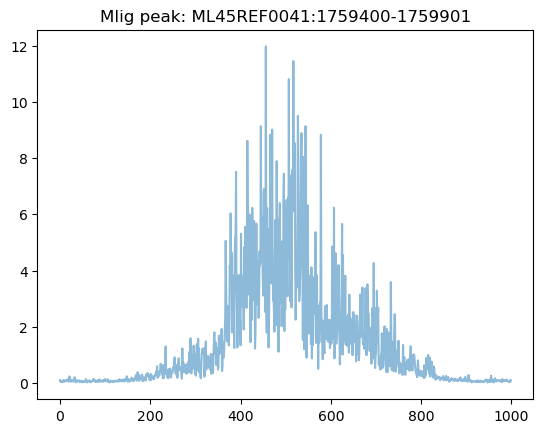

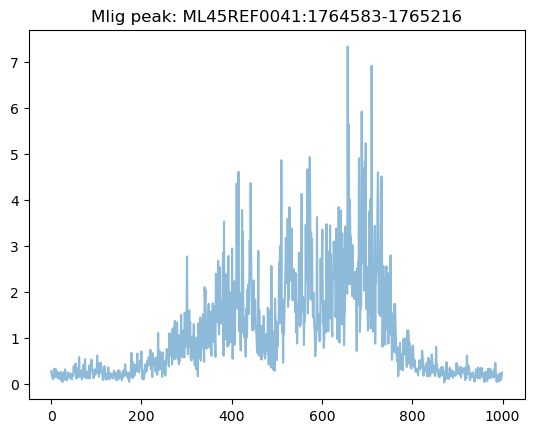

In [16]:
def plot_pred_out(preds,idx):
    logits, counts = preds
    ref_probs = softmax(logits).T
    counts_exp = np.tile(np.exp(counts),(1,1000)).T
    plt.plot((counts_exp * ref_probs)[:,idx], alpha=0.5)
    plt.title(f"Mlig peak: {peak_table.iloc[idx,0]}:{peak_table.iloc[idx,1]}-{peak_table.iloc[idx,2]}")
    plt.show()
    return
    
for i in range(len(peak_table.index)):
    plot_pred_out(pred,i)



In [17]:
model_profile_explainers = shap.explainers.deep.TFDeepExplainer(
    (model_g.input, get_weightedsum_meannormed_logits(model_g)),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)
profile_shap_scores = np.array(model_profile_explainers.shap_values(
    onehot_seq, progress_message=200))
profile_scores_dict = generate_shap_dict(onehot_seq, profile_shap_scores)
project_shap_scores = np.multiply(onehot_seq,profile_shap_scores)



Done 0 examples of 2
(2, 2114, 4) (2, 2114, 4)


In [18]:
profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
    (model_g.input, tf.reduce_sum(model_g.outputs[1], axis=-1)),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)
counts_shap_scores = np.array(profile_model_counts_explainer.shap_values(
    onehot_seq, progress_message=100))
print(counts_shap_scores.shape)
counts_scores_dict = generate_shap_dict(onehot_seq, counts_shap_scores)
counts_shap_scores = np.multiply(onehot_seq,counts_shap_scores)


Done 0 examples of 2
(2, 2114, 4)
(2, 2114, 4) (2, 2114, 4)


In [19]:
### Let's add motif instance within this peak region 
neural = pd.read_csv('./Motif_filtration/Mlig/neural_mean_motifs_SHAP_filtered.tsv',sep="\t")
neural['peak'] = neural['peak_chrom'] + ':' + (neural['peak_start']+1).astype(str) + '-' + neural['peak_end'].astype(str)

In [20]:
promoter_peak = ['ML45REF0041:1759400-1759901']
distal_peak = ['ML45REF0041:1764583-1765216']
promoter_motifs = neural[neural.peak.isin(promoter_peak)]
distal_motifs = neural[neural.peak.isin(distal_peak)]

### Filtered motifs that get plotted 
Mlig_promoter_list = ['JC_0094', 'JC_0118', 'JC_0398', 'JC_0318', 'JC_0050', 
             'JC_0142', 'JC_0185', 'WC_0968', 'WC_0614'] 

promoter_motifs = promoter_motifs[promoter_motifs.key.isin(Mlig_promoter_list)]
promoter_motifs = promoter_motifs.drop([1136048,1136059,1136058,1136065,1136066,1136047])
promoter_motifs = promoter_motifs[['key','motif_rel_start_new','motif_rel_end_new','motif_sum','motif_mean']]

## Make a dataframe for motifs not in there 
manual_add = pd.DataFrame({'key': ['JC_0123', 'JC_0255', 'JC_0255'],
           'motif_rel_start_new': [851, 1091, 1109],
           'motif_rel_end_new': [861, 1100, 1120],
           'motif_sum': [np.sum(counts_scores_dict["projected_shap"]["seq"][0][:,851:859]),
                         np.sum(counts_scores_dict["projected_shap"]["seq"][0][:,1091:1100]),
                         np.sum(counts_scores_dict["projected_shap"]["seq"][0][:,1109:1120])],
           'motif_mean': [np.mean(counts_scores_dict["projected_shap"]["seq"][0][:,851:859]),
                          np.mean(counts_scores_dict["projected_shap"]["seq"][0][:,1091:1100]),
                          np.mean(counts_scores_dict["projected_shap"]["seq"][0][:,1109:1120])]})

Mlig_promoter = pd.concat([promoter_motifs,manual_add],axis=0).sort_values(by='motif_rel_start_new')
Mlig_promoter['mean_min_max'] = min_max_norm(Mlig_promoter['motif_mean'])
Mlig_promoter['key_unique'] = 'Mlig_promoter'+'_'+ Mlig_promoter['key']+'_'+Mlig_promoter['motif_rel_start_new'].astype(str)

### Distal 
Mlig_distal_list = ['JC_0172', 'JC_0028', 'WC_0061', 'JC_0211', 'JC_0428', 'JC_0142']
distal_motifs = distal_motifs[distal_motifs.key.isin(Mlig_distal_list)]
index_keep = [1136076,1136070,1136071,1136074,1136153,1136077,1136128]
distal_motifs = distal_motifs[distal_motifs.index.isin(index_keep)]
distal_motifs = distal_motifs[['key','motif_rel_start_new','motif_rel_end_new','motif_sum','motif_mean']].sort_values(by='motif_rel_start_new')
distal_motifs['mean_min_max'] = min_max_norm(distal_motifs['motif_mean'])
distal_motifs['key_unique'] = 'Mlig_distal'+'_'+distal_motifs['key']+'_'+distal_motifs['motif_rel_start_new'].astype(str)


In [23]:
distal_motifs

,key,motif_rel_start_new,motif_rel_end_new,motif_sum,motif_mean,mean_min_max,key_unique
1136076,JC_0172,906,911,0.049396,0.002470,0.154153,Mlig_distal_JC_0172_906
1136070,JC_0028,991,1009,0.383581,0.005328,0.796925,Mlig_distal_JC_0028_991
1136074,JC_0142,1040,1046,0.076667,0.003194,0.317142,Mlig_distal_JC_0142_1040
1136153,WC_0061,1055,1060,0.035689,0.001784,0.000000,Mlig_distal_WC_0061_1055
1136077,JC_0211,1087,1097,0.137683,0.003442,0.372839,Mlig_distal_JC_0211_1087
1136071,JC_0028,1223,1241,0.175469,0.002437,0.146791,Mlig_distal_JC_0028_1223
1136128,JC_0428,1243,1256,0.323980,0.006230,1.000000,Mlig_distal_JC_0428_1243


In [ ]:
# This is to store such that I can actually do stuffs for trying to cluster motifs to annotate with similarities 
promoter_result = {}

# Loop through the DataFrame
for index, row in Mlig_promoter.iterrows():
    key = row['key_unique']
    start = row['motif_rel_start_new']
    end = row['motif_rel_end_new']
    
    # Slice the array
    promoter_result[key] = counts_scores_dict["projected_shap"]["seq"][1][:,start:end]

# Print the result
for key, value in promoter_result.items():
    print(f"{key}: {value}")

with open('./ChromBPNet/POU4_locus/Mlig_promoter_counts_SHAP.pkl', 'wb') as f:
    pickle.dump(promoter_result, f)

In [83]:
# This is to store such that I can actually do stuffs for trying to cluster motifs to annotate with similarities 
distal_result = {}

# Loop through the DataFrame
for index, row in distal_motifs.iterrows():
    key = row['key_unique']
    start = row['motif_rel_start_new']
    end = row['motif_rel_end_new']
    
    # Slice the array
    distal_result[key] = counts_scores_dict["projected_shap"]["seq"][1][:,start:end]

# Print the result
for key, value in distal_result.items():
    print(f"{key}: {value}")

with open('./ChromBPNet/POU4_locus/Mlig_distal_counts_SHAP.pkl', 'wb') as f:
    pickle.dump(distal_result, f)

Mlig_distal_JC_0172_906: [[-0.          0.          0.         -0.         -0.        ]
 [ 0.          0.03064389  0.          0.          0.02963112]
 [-0.00273024 -0.         -0.          0.         -0.        ]
 [ 0.          0.          0.02171933  0.01624725  0.        ]]
Mlig_distal_JC_0028_991: [[-0.          0.         -0.         -0.         -0.         -0.
  -0.00526198 -0.         -0.         -0.         -0.         -0.
  -0.         -0.          0.         -0.         -0.         -0.        ]
 [-0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.        ]
 [ 0.          0.03206809  0.0269869   0.02647783  0.02820392  0.03285731
   0.          0.          0.03017279  0.02723263  0.02453967  0.0241907
   0.01918044  0.02457282  0.01371513  0.01687101  0.02391788  0.01762208]
 [-0.01289859 -0.         -0.         -0.         -0.        

/tmp/ipykernel_6525/3027835203.py:9: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)


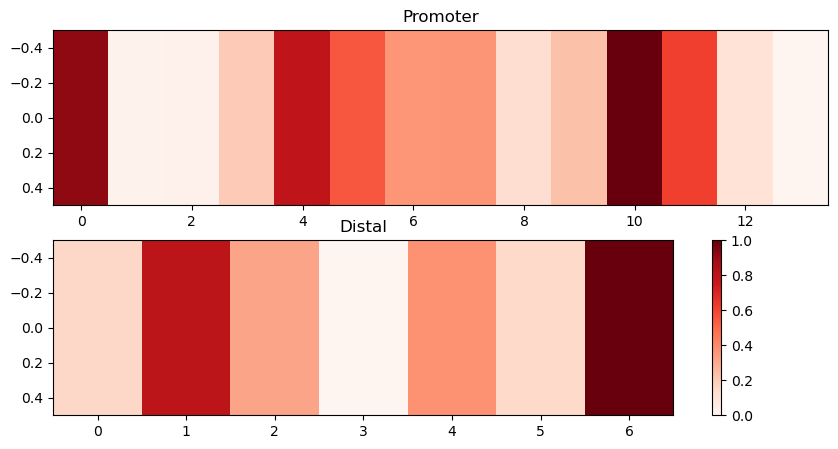

In [21]:
# Create a figure and axis
fig, ax = plt.subplots(nrows=2,figsize=(10,5))

# Plot the 1D heatmap
heatmap = ax[0].imshow([Mlig_promoter.mean_min_max.tolist()], cmap='Reds', aspect='auto',vmin=0,vmax=1)
heatmap2 = ax[1].imshow([distal_motifs.mean_min_max.tolist()], cmap='Reds', aspect='auto',vmin=0,vmax=1)

# Add a colorbar to show the scale
cbar = plt.colorbar(heatmap)

# Customize labels and title
ax[0].set_title('Promoter')
ax[1].set_title('Distal')

# Show the plot
plt.savefig("./Plots/Fig4/Panel4b_Mlig.svg",format='svg')
plt.show()

### S. mediterranea pou4-1

In [10]:
ref = pyfaidx.Fasta('./Refs/dd_Smes_g4/final_dd_Smed_g4.fa')

In [11]:
with keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll, 'tf':tf}):
    model_g = keras.models.load_model("./ChromBPNet/chrombpnet_models/Smed/fold_1/neural/neural_chrombpnet_wo_bias.h5")

2024-08-05 22:44:12.157855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-05 22:44:12.158679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-05 22:44:12.165870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-05 22:44:12.166629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-05 22:44:12.167334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [12]:
INPUT_LEN = model_g.input_shape[1]
OUT_LEN = model_g.output_shape[0][1]

INPUT_LEN, OUT_LEN

(2114, 1000)

In [13]:
## Load in macrostoma POU4 peaks 
### distal, promoter 
peak_list = ['dd_Smes_g4_21:5422599-5422795','dd_Smes_g4_21:5428190-5428445'] # POU1
Smed_POU4_peaks = pd.DataFrame(peak_list)

Smed_POU4_peaks.columns = ['Smed_peak']
Smed_POU4_peaks[['chr', 'start']] = Smed_POU4_peaks['Smed_peak'].str.split(':', expand=True)
Smed_POU4_peaks[['start', 'end']] = Smed_POU4_peaks['start'].str.split('-', expand=True)
Smed_POU4_peaks = Smed_POU4_peaks.drop(columns=['Smed_peak'])
Smed_POU4_peaks['start'] =Smed_POU4_peaks['start'].astype(int)
Smed_POU4_peaks['end'] = Smed_POU4_peaks['end'].astype(int)

all_peaks = pd.read_csv("./Peaks/Smed.merged_peaks.narrowPeak",sep="\t",header=None)
all_peaks.columns = ['chr','start','end','Peak_index','score','strand','X','Y','Z','summit']
all_peaks = all_peaks[['chr','start','end','summit']]
all_peaks['start'] = all_peaks['start']+1

peak_table = pd.merge(Smed_POU4_peaks,all_peaks,how = "left",on=["chr","start","end"])


In [14]:
sequences = []
buffer = 500
for i,x in peak_table.iterrows():
    sequence = str(ref[x['chr']][((x['start']+x['summit']) - INPUT_LEN//2):((x['start']+x['summit']) + INPUT_LEN//2)])
    if len(sequence)==2114:
        sequence = sequence[:INPUT_LEN]
        sequences.append(sequence)
    else: 
        print(i)

onehot_seq = []
for i in range(len(sequences)):
    onehot_seq.append(dna_to_one_hot(sequences[i]).reshape(1,-1,4))

onehot_seq = np.concatenate( onehot_seq, axis=0 )
print(onehot_seq.shape)

(2, 2114, 4)


In [15]:
pred = model_g.predict(onehot_seq)

/opt/conda/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-08-05 22:44:16.718049: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


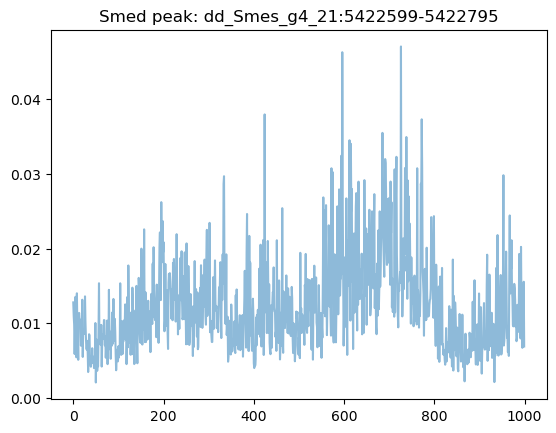

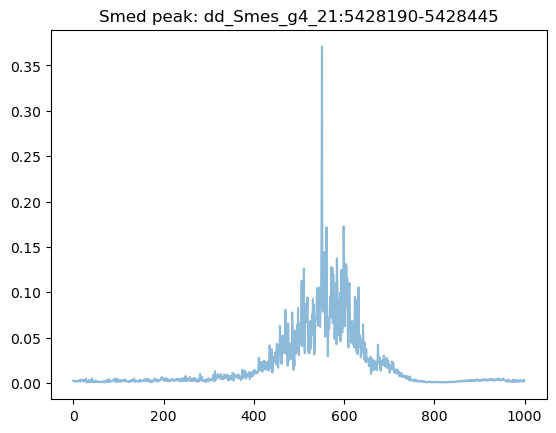

In [16]:
def plot_pred_out(preds,idx):
    logits, counts = preds
    ref_probs = softmax(logits).T
    counts_exp = np.tile(np.exp(counts),(1,1000)).T
    plt.plot((counts_exp * ref_probs)[:,idx], alpha=0.5)
    plt.title(f"Smed peak: {peak_table.iloc[idx,0]}:{peak_table.iloc[idx,1]}-{peak_table.iloc[idx,2]}")
    plt.show()
    return
    
for i in range(len(peak_table.index)):
    plot_pred_out(pred,i)



In [44]:
model_profile_explainers = shap.explainers.deep.TFDeepExplainer(
    (model_g.input, get_weightedsum_meannormed_logits(model_g)),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)
profile_shap_scores = np.array(model_profile_explainers.shap_values(
    onehot_seq, progress_message=200))
profile_scores_dict = generate_shap_dict(onehot_seq, profile_shap_scores)
project_shap_scores = np.multiply(onehot_seq,profile_shap_scores)


Done 0 examples of 2
(2, 2114, 4) (2, 2114, 4)


In [18]:
profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
    (model_g.input, tf.reduce_sum(model_g.outputs[1], axis=-1)),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)
counts_shap_scores = np.array(profile_model_counts_explainer.shap_values(
    onehot_seq, progress_message=100))
print(counts_shap_scores.shape)
counts_scores_dict = generate_shap_dict(onehot_seq, counts_shap_scores)
counts_shap_scores = np.multiply(onehot_seq,counts_shap_scores)


Done 0 examples of 2
(2, 2114, 4)
(2, 2114, 4) (2, 2114, 4)


In [46]:
### Let's add motif instance within this peak region 
neural = pd.read_csv('./Motif_filtration/Smed/neural_mean_motifs_SHAP_filtered.tsv',sep="\t")
neural['peak'] = neural['peak_chrom'] + ':' + (neural['peak_start']+1).astype(str) + '-' + neural['peak_end'].astype(str)

In [34]:
## Our POU4 
promoter_peak = ['dd_Smes_g4_21:5428190-5428445'] 
distal_peak = ['dd_Smes_g4_21:5422599-5422795']
promoter_peak = neural[neural.peak.isin(promoter_peak)]
distal_peak = neural[neural.peak.isin(distal_peak)]
index_keep = [1580604,1580608,1580610,1580613]
promoter_peak = promoter_peak[promoter_peak.index.isin(index_keep)] 
promoter_peak = promoter_peak[['key','motif_rel_start_new','motif_rel_end_new','motif_sum','motif_mean']].sort_values(by='motif_rel_start_new')
manual_add = pd.DataFrame({'key': ['JC_0030'],
           'motif_rel_start_new': [1012],
           'motif_rel_end_new': [1025],
           'motif_sum': [np.sum(counts_scores_dict["projected_shap"]["seq"][1][:,1012:1025])],
           'motif_mean': [np.mean(counts_scores_dict["projected_shap"]["seq"][1][:,1012:1025])]})

Smed_promoter = pd.concat([promoter_peak,manual_add],axis=0).sort_values(by='motif_rel_start_new')
Smed_promoter['mean_min_max'] = min_max_norm(Smed_promoter['motif_mean'])
Smed_promoter['key_unique'] = 'Smed_promoter_POU1'+'_'+Smed_promoter['key']+'_'+Smed_promoter['motif_rel_start_new'].astype(str)

index_distal = [1210740]
distal_peak = distal_peak[distal_peak.index.isin(index_distal)]
distal_peak = distal_peak[['key','motif_rel_start_new','motif_rel_end_new','motif_sum','motif_mean']]
manual_add = pd.DataFrame({'key': ['JC_0255'],
           'motif_rel_start_new': [1256],
           'motif_rel_end_new': [1270],
           'motif_sum': [np.sum(counts_scores_dict["projected_shap"]["seq"][0][:,1256:1269])],
           'motif_mean': [np.mean(counts_scores_dict["projected_shap"]["seq"][0][:,1256:1269])]})

Smed_distal = pd.concat([distal_peak,manual_add],axis=0).sort_values(by='motif_rel_start_new')
Smed_distal['mean_min_max'] = min_max_norm(Smed_distal['motif_mean'])
Smed_distal['key_unique'] = 'Smed_distal_POU1'+'_'+Smed_distal['key']+'_'+Smed_distal['motif_rel_start_new'].astype(str)



In [35]:
Smed_promoter

,key,motif_rel_start_new,motif_rel_end_new,motif_sum,motif_mean,mean_min_max,key_unique
1580604,JC_0047,1003,1008,0.018190,0.000910,0.024700,Smed_promoter_POU1_JC_0047_1003
0,JC_0030,1012,1025,0.053805,0.001035,0.045338,Smed_promoter_POU1_JC_0030_1012
1580608,JC_0080,1074,1080,0.163818,0.006826,1.000000,Smed_promoter_POU1_JC_0080_1074
1580610,JC_0268,1132,1144,0.036465,0.000760,0.000000,Smed_promoter_POU1_JC_0268_1132
1580613,WC_0968,1166,1170,0.018545,0.001159,0.065843,Smed_promoter_POU1_WC_0968_1166


In [36]:
Smed_distal

,key,motif_rel_start_new,motif_rel_end_new,motif_sum,motif_mean,mean_min_max,key_unique
1210740,JC_0047,994,999,0.021234,0.001062,1.0,Smed_distal_POU1_JC_0047_994
0,JC_0255,1256,1270,0.041738,0.000803,0.0,Smed_distal_POU1_JC_0255_1256


In [ ]:
# Dictionary to store the results for clustering motifs purposes 
promoter_result = {}

# Loop through the DataFrame
for index, row in Smed_promoter.iterrows():
    key = row['key_unique']
    start = row['motif_rel_start_new']
    end = row['motif_rel_end_new']
    
    # Slice the array
    promoter_result[key] = counts_scores_dict["projected_shap"]["seq"][0][:,start:end]

# Print the result
for key, value in promoter_result.items():
    print(f"{key}: {value}")

with open('./ChromBPNet/POU4_locus/Smed_POU1_promoter_counts_SHAP.pkl', 'wb') as f:
    pickle.dump(promoter_result, f)

In [24]:
# Dictionary to store the results for clustering motifs purposes 
import pickle
distal_result = {}

# Loop through the DataFrame
for index, row in Smed_distal.iterrows():
    key = row['key_unique']
    start = row['motif_rel_start_new']
    end = row['motif_rel_end_new']
    
    # Slice the array
    distal_result[key] = counts_scores_dict["projected_shap"]["seq"][0][:,start:end]

# Print the result
for key, value in distal_result.items():
    print(f"{key}: {value}")

with open('./ChromBPNet/POU4_locus/Smed_POU1_distal_counts_SHAP.pkl', 'wb') as f:
    pickle.dump(distal_result, f)

Smed_distal_POU1_JC_0047_994: [[ 0.00259214 -0.          0.          0.00205268  0.        ]
 [-0.         -0.          0.          0.          0.        ]
 [-0.         -0.         -0.         -0.          0.        ]
 [-0.          0.00509764  0.00928771  0.          0.00360311]]
Smed_distal_POU1_JC_0255_1256: [[ 0.         -0.          0.00471843  0.00382855  0.         -0.
   0.00372754  0.          0.          0.         -0.00152098  0.
   0.          0.        ]
 [-0.          0.         -0.         -0.         -0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.00688387 -0.          0.         -0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.00161583 -0.         -0.         -0.          0.00422083  0.00268719
   0.          0.00562624  0.00270988  0.00117468 -0.          0.00183
   0.00079363  0.00268128]]


/tmp/ipykernel_8290/1688568656.py:9: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)


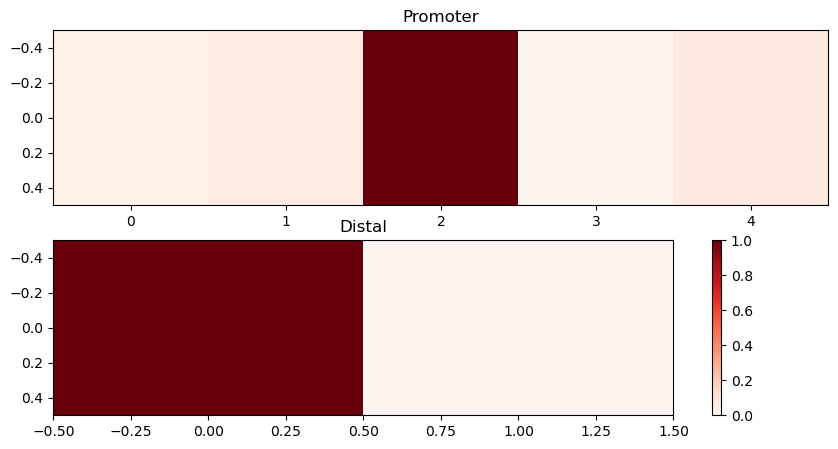

In [35]:
# Create a figure and axis
fig, ax = plt.subplots(nrows=2,figsize=(10,5))

# Plot the 1D heatmap
heatmap = ax[0].imshow([Smed_promoter.mean_min_max.tolist()], cmap='Reds', aspect='auto',vmin=0,vmax=1)
heatmap2 = ax[1].imshow([Smed_distal.mean_min_max.tolist()], cmap='Reds', aspect='auto',vmin=0,vmax=1)

# Add a colorbar to show the scale
cbar = plt.colorbar(heatmap)

# Customize labels and title
ax[0].set_title('Promoter')
ax[1].set_title('Distal')

# Show the plot
plt.savefig("./Plots/Fig4/Panel4b_Smed_1.svg",format='svg')
plt.show()

### S.mediterranea POU4-2

In [40]:
## Load in macrostoma POU4 peaks 
### distal, promoter 
peak_list = ['dd_Smes_g4_145:1529234-1529767','dd_Smes_g4_145:1531880-1532265'] #POU2 
Smed_POU4_peaks = pd.DataFrame(peak_list)

Smed_POU4_peaks.columns = ['Smed_peak']
Smed_POU4_peaks[['chr', 'start']] = Smed_POU4_peaks['Smed_peak'].str.split(':', expand=True)
Smed_POU4_peaks[['start', 'end']] = Smed_POU4_peaks['start'].str.split('-', expand=True)
Smed_POU4_peaks = Smed_POU4_peaks.drop(columns=['Smed_peak'])
Smed_POU4_peaks['start'] =Smed_POU4_peaks['start'].astype(int)
Smed_POU4_peaks['end'] = Smed_POU4_peaks['end'].astype(int)

all_peaks = pd.read_csv("./Peaks/Smed.merged_peaks.narrowPeak",sep="\t",header=None)
all_peaks.columns = ['chr','start','end','Peak_index','score','strand','X','Y','Z','summit']
all_peaks = all_peaks[['chr','start','end','summit']]
all_peaks['start'] = all_peaks['start']+1

peak_table = pd.merge(Smed_POU4_peaks,all_peaks,how = "left",on=["chr","start","end"])


In [41]:
sequences = []
buffer = 500
for i,x in peak_table.iterrows():
    sequence = str(ref[x['chr']][((x['start']+x['summit']) - INPUT_LEN//2):((x['start']+x['summit']) + INPUT_LEN//2)])
    if len(sequence)==2114:
        sequence = sequence[:INPUT_LEN]
        sequences.append(sequence)
    else: 
        print(i)

onehot_seq = []
for i in range(len(sequences)):
    onehot_seq.append(dna_to_one_hot(sequences[i]).reshape(1,-1,4))

onehot_seq = np.concatenate( onehot_seq, axis=0 )
print(onehot_seq.shape)

(2, 2114, 4)


In [42]:
pred = model_g.predict(onehot_seq)

/opt/conda/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


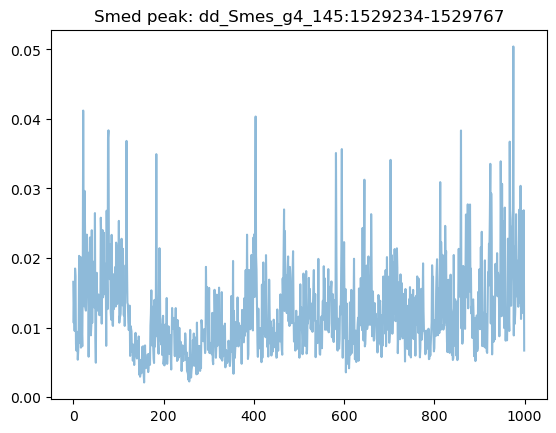

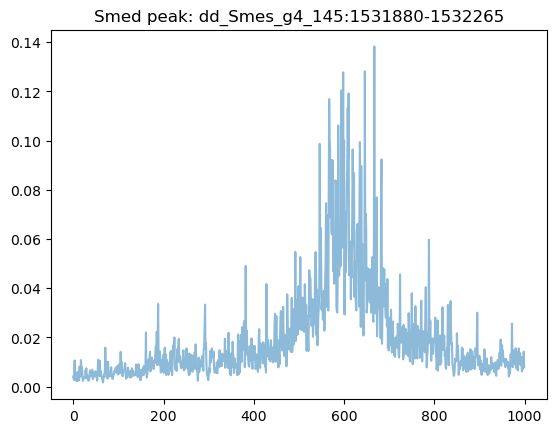

In [43]:
def plot_pred_out(preds,idx):
    logits, counts = preds
    ref_probs = softmax(logits).T
    counts_exp = np.tile(np.exp(counts),(1,1000)).T
    plt.plot((counts_exp * ref_probs)[:,idx], alpha=0.5)
    plt.title(f"Smed peak: {peak_table.iloc[idx,0]}:{peak_table.iloc[idx,1]}-{peak_table.iloc[idx,2]}")
    plt.show()
    return
    
for i in range(len(peak_table.index)):
    plot_pred_out(pred,i)



In [44]:
model_profile_explainers = shap.explainers.deep.TFDeepExplainer(
    (model_g.input, get_weightedsum_meannormed_logits(model_g)),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)
profile_shap_scores = np.array(model_profile_explainers.shap_values(
    onehot_seq, progress_message=200))
profile_scores_dict = generate_shap_dict(onehot_seq, profile_shap_scores)
project_shap_scores = np.multiply(onehot_seq,profile_shap_scores)


Done 0 examples of 2
(2, 2114, 4) (2, 2114, 4)


In [18]:
profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
    (model_g.input, tf.reduce_sum(model_g.outputs[1], axis=-1)),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)
counts_shap_scores = np.array(profile_model_counts_explainer.shap_values(
    onehot_seq, progress_message=100))
print(counts_shap_scores.shape)
counts_scores_dict = generate_shap_dict(onehot_seq, counts_shap_scores)
counts_shap_scores = np.multiply(onehot_seq,counts_shap_scores)


Done 0 examples of 2
(2, 2114, 4)
(2, 2114, 4) (2, 2114, 4)


In [46]:
### Let's add motif instance within this peak region 
neural = pd.read_csv('./Motif_filtration/Smed/neural_mean_motifs_SHAP_filtered.tsv',sep="\t")
neural['peak'] = neural['peak_chrom'] + ':' + (neural['peak_start']+1).astype(str) + '-' + neural['peak_end'].astype(str)

In [47]:
## Peter's POU4
promoter_peak = ['dd_Smes_g4_145:1531880-1532265']
distal_peak = ['dd_Smes_g4_145:1529234-1529767']
promoter_peak = neural[neural.peak.isin(promoter_peak)]
distal_peak = neural[neural.peak.isin(distal_peak)]
index_keep = [277343,277334,277346,277347,277344,277341,277349,277340]
promoter_peak = promoter_peak[promoter_peak.index.isin(index_keep)] 
promoter_peak = promoter_peak[['key','motif_rel_start_new','motif_rel_end_new','motif_sum','motif_mean']].sort_values(by='motif_rel_start_new')
promoter_peak['mean_min_max'] = min_max_norm(promoter_peak['motif_mean'])
promoter_peak['key_unique'] = 'Smed_promoter_POU2'+'_'+promoter_peak['key']+'_'+promoter_peak['motif_rel_start_new'].astype(str)

## distal peak 
distal_index = [1125812,1125813,1125814,1125815,1125818,1125816,1125817]
distal_peak = distal_peak[distal_peak.index.isin(distal_index)]
distal_peak = distal_peak[['key','motif_rel_start_new','motif_rel_end_new','motif_sum','motif_mean']].sort_values(by='motif_rel_start_new')
distal_peak['mean_min_max'] = min_max_norm(distal_peak['motif_mean'])
distal_peak['key_unique'] = 'Smed_distal_POU2'+'_'+distal_peak['key']+'_'+distal_peak['motif_rel_start_new'].astype(str)


In [48]:
promoter_peak

,key,motif_rel_start_new,motif_rel_end_new,motif_sum,motif_mean,mean_min_max,key_unique
277343,JC_0316,920,925,0.021187,0.001059,0.072310,Smed_promoter_POU2_JC_0316_920
277334,JC_0047,953,958,0.015822,0.000791,0.029433,Smed_promoter_POU2_JC_0047_953
277346,JC_0392,1098,1113,0.096185,0.001603,0.159224,Smed_promoter_POU2_JC_0392_1098
277347,WC_0747,1118,1142,0.058268,0.000607,0.000000,Smed_promoter_POU2_WC_0747_1118
277344,JC_0334,1141,1150,0.127522,0.003542,0.469187,Smed_promoter_POU2_JC_0334_1141
277341,JC_0080,1151,1157,0.164715,0.006863,1.000000,Smed_promoter_POU2_JC_0080_1151
277349,WC_0968,1207,1211,0.013565,0.000848,0.038503,Smed_promoter_POU2_WC_0968_1207
277340,JC_0075,1246,1251,0.019121,0.000956,0.055796,Smed_promoter_POU2_JC_0075_1246


In [49]:
distal_peak

,key,motif_rel_start_new,motif_rel_end_new,motif_sum,motif_mean,mean_min_max,key_unique
1125812,JC_0075,994,999,0.026994,0.001350,1.000000,Smed_distal_POU2_JC_0075_994
1125813,JC_0096,1010,1014,0.013003,0.000813,0.000000,Smed_distal_POU2_JC_0096_1010
1125814,JC_0108,1070,1075,0.021995,0.001100,0.534517,Smed_distal_POU2_JC_0108_1070
1125815,JC_0115,1083,1088,0.016976,0.000849,0.067213,Smed_distal_POU2_JC_0115_1083
1125818,JC_0352,1092,1105,0.061368,0.001180,0.684282,Smed_distal_POU2_JC_0352_1092
1125816,JC_0200,1226,1233,0.035252,0.001259,0.831067,Smed_distal_POU2_JC_0200_1226
1125817,JC_0316,1325,1330,0.023093,0.001155,0.636794,Smed_distal_POU2_JC_0316_1325


In [ ]:
# Dictionary to store the results for clustering motifs purposes 
promoter_result = {}

# Loop through the DataFrame
for index, row in promoter_peak.iterrows():
    key = row['key_unique']
    start = row['motif_rel_start_new']
    end = row['motif_rel_end_new']
    
    # Slice the array
    promoter_result[key] = counts_scores_dict["projected_shap"]["seq"][0][:,start:end]

# Print the result
for key, value in promoter_result.items():
    print(f"{key}: {value}")

with open('./ChromBPNet/POU4_locus/Smed_POU2_promoter_counts_SHAP.pkl', 'wb') as f:
    pickle.dump(promoter_result, f)

In [ ]:
# Dictionary to store the results for clustering motifs purposes 
import pickle
distal_result = {}

# Loop through the DataFrame
for index, row in distal_peak.iterrows():
    key = row['key_unique']
    start = row['motif_rel_start_new']
    end = row['motif_rel_end_new']
    
    # Slice the array
    distal_result[key] = counts_scores_dict["projected_shap"]["seq"][0][:,start:end]

# Print the result
for key, value in distal_result.items():
    print(f"{key}: {value}")

with open('./ChromBPNet/POU4_locus/Smed_POU2_distal_counts_SHAP.pkl', 'wb') as f:
    pickle.dump(distal_result, f)

/tmp/ipykernel_8564/1995053158.py:9: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)


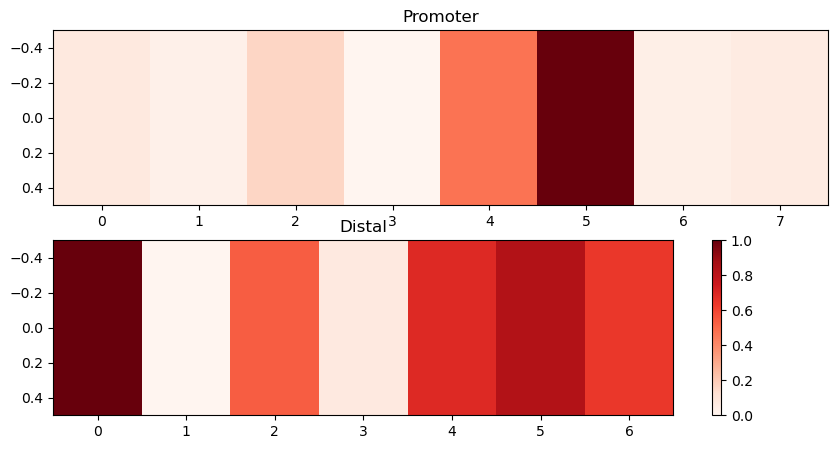

In [54]:
# Create a figure and axis
fig, ax = plt.subplots(nrows=2,figsize=(10,5))

# Plot the 1D heatmap
heatmap = ax[0].imshow([promoter_peak.mean_min_max.tolist()], cmap='Reds', aspect='auto',vmin=0,vmax=1)
heatmap2 = ax[1].imshow([distal_peak.mean_min_max.tolist()], cmap='Reds', aspect='auto',vmin=0,vmax=1)

# Add a colorbar to show the scale
cbar = plt.colorbar(heatmap)

# Customize labels and title
ax[0].set_title('Promoter')
ax[1].set_title('Distal')

# Show the plot
plt.savefig("./Plots/Fig4/Panel4b_Smed_2.svg",format='svg')
plt.show()

### S.mansoni POU4

In [26]:
ref = pyfaidx.Fasta('./Refs/SM_V7/Schisto_PRJEA36577.WBPS15.genomic.fa')

In [27]:
with keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll, 'tf':tf}):
    model_g = keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/neural/neural_chrombpnet_wo_bias.h5")

In [28]:
INPUT_LEN = model_g.input_shape[1]
OUT_LEN = model_g.output_shape[0][1]

INPUT_LEN, OUT_LEN

(2114, 1000)

In [29]:
## Load in schisto POU4 peaks 
# distal, promoter 
peak_list = ['SM_V7_4:20339587-20340292','SM_V7_4:20358303-20358789']
Sman_POU4_peaks = pd.DataFrame(peak_list)

Sman_POU4_peaks.columns = ['Sman_peak']
Sman_POU4_peaks[['chr', 'start']] = Sman_POU4_peaks['Sman_peak'].str.split(':', expand=True)
Sman_POU4_peaks[['start', 'end']] = Sman_POU4_peaks['start'].str.split('-', expand=True)
Sman_POU4_peaks = Sman_POU4_peaks.drop(columns=['Sman_peak'])
Sman_POU4_peaks['start'] =Sman_POU4_peaks['start'].astype(int)
Sman_POU4_peaks['end'] = Sman_POU4_peaks['end'].astype(int)

all_peaks = pd.read_csv("./Peaks/Sman.merged_peaks.narrowPeak",sep="\t",header=None)
all_peaks.columns = ['chr','start','end','Peak_index','score','strand','X','Y','Z','summit']
all_peaks = all_peaks[['chr','start','end','summit']]
all_peaks['start'] = all_peaks['start']+1

peak_table = pd.merge(Sman_POU4_peaks,all_peaks,how = "left",on=["chr","start","end"])


In [30]:
sequences = []
buffer = 500
for i,x in peak_table.iterrows():
    sequence = str(ref[x['chr']][((x['start']+x['summit']) - INPUT_LEN//2):((x['start']+x['summit']) + INPUT_LEN//2)])
    if len(sequence)==2114:
        sequence = sequence[:INPUT_LEN]
        sequences.append(sequence)
    else: 
        print(i)

onehot_seq = []
for i in range(len(sequences)):
    onehot_seq.append(dna_to_one_hot(sequences[i]).reshape(1,-1,4))

onehot_seq = np.concatenate( onehot_seq, axis=0 )
print(onehot_seq.shape)

(2, 2114, 4)


In [31]:
pred = model_g.predict(onehot_seq)

/opt/conda/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


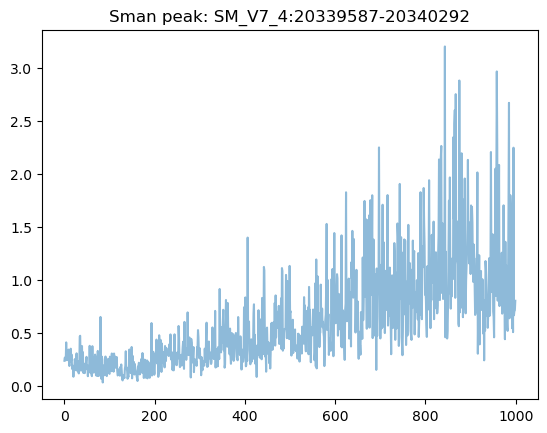

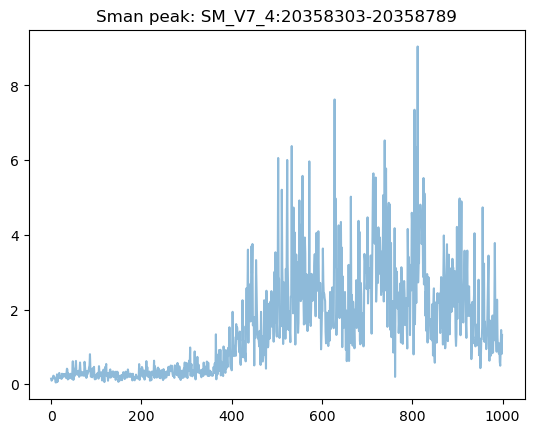

In [32]:
def plot_pred_out(preds,idx):
    logits, counts = preds
    ref_probs = softmax(logits).T
    counts_exp = np.tile(np.exp(counts),(1,1000)).T
    plt.plot((counts_exp * ref_probs)[:,idx], alpha=0.5)
    plt.title(f"Sman peak: {peak_table.iloc[idx,0]}:{peak_table.iloc[idx,1]}-{peak_table.iloc[idx,2]}")
    plt.show()
    return
    
for i in range(len(peak_table.index)):
    plot_pred_out(pred,i)



In [57]:
model_profile_explainers = shap.explainers.deep.TFDeepExplainer(
    (model_g.input, get_weightedsum_meannormed_logits(model_g)),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)
profile_shap_scores = np.array(model_profile_explainers.shap_values(
    onehot_seq, progress_message=200))
profile_scores_dict = generate_shap_dict(onehot_seq, profile_shap_scores)
project_shap_scores = np.multiply(onehot_seq,profile_shap_scores)


Done 0 examples of 2
(2, 2114, 4) (2, 2114, 4)


In [58]:
profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
    (model_g.input, tf.reduce_sum(model_g.outputs[1], axis=-1)),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)
counts_shap_scores = np.array(profile_model_counts_explainer.shap_values(
    onehot_seq, progress_message=100))
print(counts_shap_scores.shape)
counts_scores_dict = generate_shap_dict(onehot_seq, counts_shap_scores)
counts_shap_scores = np.multiply(onehot_seq,counts_shap_scores)


Done 0 examples of 2
(2, 2114, 4)
(2, 2114, 4) (2, 2114, 4)


In [59]:
### Let's add motif instance within this peak region 
neural = pd.read_csv('./Motif_filtration/Sman/neural_mean_motifs_SHAP_filtered.tsv',sep="\t")
neural['peak'] = neural['peak_chrom'] + ':' + (neural['peak_start']+1).astype(str) + '-' + neural['peak_end'].astype(str)

In [60]:
## distal, promoter 
promoter_peak = ['SM_V7_4:20358303-20358789'] 
distal_peak = ['SM_V7_4:20339587-20340292']
promoter_peak = neural[neural.peak.isin(promoter_peak)]
distal_peak = neural[neural.peak.isin(distal_peak)]

index_keep = [1646729,1646722,1646720,1646718,1646723,1646735,1646739,1646724,1646733,1646719]
promoter_peak = promoter_peak[promoter_peak.index.isin(index_keep)] 
promoter_peak = promoter_peak[['key','motif_rel_start_new','motif_rel_end_new','motif_sum','motif_mean']].sort_values(by='motif_rel_start_new')
manual_add = pd.DataFrame({'key': ['JC_0123'],
           'motif_rel_start_new': [1108],
           'motif_rel_end_new': [1118],
           'motif_sum': [np.sum(counts_scores_dict["projected_shap"]["seq"][1][:,1108:1118])],
           'motif_mean': [np.mean(counts_scores_dict["projected_shap"]["seq"][1][:,1108:1118])]})

Sman_promoter = pd.concat([promoter_peak,manual_add],axis=0).sort_values(by='motif_rel_start_new')
Sman_promoter['mean_min_max'] = min_max_norm(Sman_promoter['motif_mean'])
Sman_promoter['key_unique'] = 'Sman_promoter'+'_'+Sman_promoter['key']+'_'+Sman_promoter['motif_rel_start_new'].astype(str)

index_distal = [76639,76630,76649,76660,76636,
                76650,76628,76640,76631,76651,76645]
distal_peak = distal_peak[distal_peak.index.isin(index_distal)]
distal_peak = distal_peak[['key','motif_rel_start_new','motif_rel_end_new','motif_sum','motif_mean']].sort_values(by='motif_rel_start_new')
distal_peak['mean_min_max'] = min_max_norm(distal_peak['motif_mean'])
distal_peak['key_unique'] = 'Sman_distal'+'_'+distal_peak['key']+'_'+distal_peak['motif_rel_start_new'].astype(str)


In [61]:
Sman_promoter

,key,motif_rel_start_new,motif_rel_end_new,motif_sum,motif_mean,mean_min_max,key_unique
1646729,WC_0853,1053,1079,0.235194,0.002261,0.082540,Sman_promoter_WC_0853_1053
1646722,JC_0303,1094,1098,0.022168,0.001385,0.000000,Sman_promoter_JC_0303_1094
0,JC_0123,1108,1118,0.479931,0.011998,1.000000,Sman_promoter_JC_0123_1108
1646720,JC_0216,1132,1145,0.123755,0.002380,0.093698,Sman_promoter_JC_0216_1132
1646718,JC_0142,1143,1149,0.064143,0.002673,0.121282,Sman_promoter_JC_0142_1143
1646723,JC_0303,1155,1159,0.046517,0.002907,0.143392,Sman_promoter_JC_0303_1155
1646735,WC_0968,1195,1199,0.029247,0.001828,0.041689,Sman_promoter_WC_0968_1195
1646739,WC_1517,1206,1229,0.194397,0.002113,0.068551,Sman_promoter_WC_1517_1206
1646724,JC_0303,1259,1263,0.022295,0.001393,0.000748,Sman_promoter_JC_0303_1259
1646733,WC_0943,1330,1342,0.418409,0.008717,0.690805,Sman_promoter_WC_0943_1330


In [62]:
distal_peak

,key,motif_rel_start_new,motif_rel_end_new,motif_sum,motif_mean,mean_min_max,key_unique
76639,JC_0038,855,860,0.044184,0.002209,0.315659,Sman_distal_JC_0038_855
76630,JC_0006,873,879,0.032909,0.001371,0.038783,Sman_distal_JC_0006_873
76649,JC_0407,991,1005,0.174482,0.003116,0.615196,Sman_distal_JC_0407_991
76660,WC_0470,1193,1202,0.154094,0.004280,1.000000,Sman_distal_WC_0470_1193
76636,JC_0019,1213,1218,0.072945,0.003647,0.790814,Sman_distal_JC_0019_1213
76650,JC_0416,1218,1224,0.036886,0.001537,0.093546,Sman_distal_JC_0416_1218
76628,JC_0000,1335,1340,0.027568,0.001378,0.041165,Sman_distal_JC_0000_1335
76640,JC_0084,1376,1382,0.091849,0.003827,0.850212,Sman_distal_JC_0084_1376
76631,JC_0019,1399,1404,0.042882,0.002144,0.294163,Sman_distal_JC_0019_1399
76651,JC_0418,1409,1416,0.035107,0.001254,0.000000,Sman_distal_JC_0418_1409


In [25]:
# Dictionary to store the results
promoter_result = {}

# Loop through the DataFrame
for index, row in Sman_promoter.iterrows():
    key = row['key_unique']
    start = row['motif_rel_start_new']
    end = row['motif_rel_end_new']
    
    # Slice the array
    promoter_result[key] = counts_scores_dict["projected_shap"]["seq"][0][:,start:end]

# Print the result
for key, value in promoter_result.items():
    print(f"{key}: {value}")

with open('./ChromBPNet/POU4_locus/Sman_promoter_counts_SHAP.pkl', 'wb') as f:
    pickle.dump(promoter_result, f)

Sman_distal_JC_0038_855: [[ 0.00720144  0.00148285  0.          0.          0.00068724]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.00302762  0.          0.        ]
 [-0.          0.          0.          0.00497393  0.        ]]
Sman_distal_JC_0006_873: [[ 0.00798038 -0.          0.0083706  -0.          0.00142256 -0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.         -0.          0.         -0.         -0.          0.        ]
 [-0.          0.00464559 -0.          0.00486349 -0.          0.00391047]]
Sman_distal_JC_0407_991: [[ 0.00396071 -0.         -0.         -0.          0.          0.
   0.00876192  0.          0.         -0.          0.00556721  0.00091054
   0.          0.        ]
 [ 0.         -0.          0.          0.02200461  0.00576507  0.03116948
   0.          0.04580457  0.03295852  0.02908416  0.          0.
   0.00317175  0.00552237]
 [ 0.          0.00303519 -0.        

In [25]:
# Dictionary to store the results
distal_result = {}

# Loop through the DataFrame
for index, row in distal_peak.iterrows():
    key = row['key_unique']
    start = row['motif_rel_start_new']
    end = row['motif_rel_end_new']
    
    # Slice the array
    distal_result[key] = counts_scores_dict["projected_shap"]["seq"][0][:,start:end]

# Print the result
for key, value in distal_result.items():
    print(f"{key}: {value}")

with open('./ChromBPNet/POU4_locus/Sman_distal_counts_SHAP.pkl', 'wb') as f:
    pickle.dump(distal_result, f)

Sman_distal_JC_0038_855: [[ 0.00720144  0.00148285  0.          0.          0.00068724]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.00302762  0.          0.        ]
 [-0.          0.          0.          0.00497393  0.        ]]
Sman_distal_JC_0006_873: [[ 0.00798038 -0.          0.0083706  -0.          0.00142256 -0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.         -0.          0.         -0.         -0.          0.        ]
 [-0.          0.00464559 -0.          0.00486349 -0.          0.00391047]]
Sman_distal_JC_0407_991: [[ 0.00396071 -0.         -0.         -0.          0.          0.
   0.00876192  0.          0.         -0.          0.00556721  0.00091054
   0.          0.        ]
 [ 0.         -0.          0.          0.02200461  0.00576507  0.03116948
   0.          0.04580457  0.03295852  0.02908416  0.          0.
   0.00317175  0.00552237]
 [ 0.          0.00303519 -0.        

/tmp/ipykernel_9936/1240569060.py:9: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)


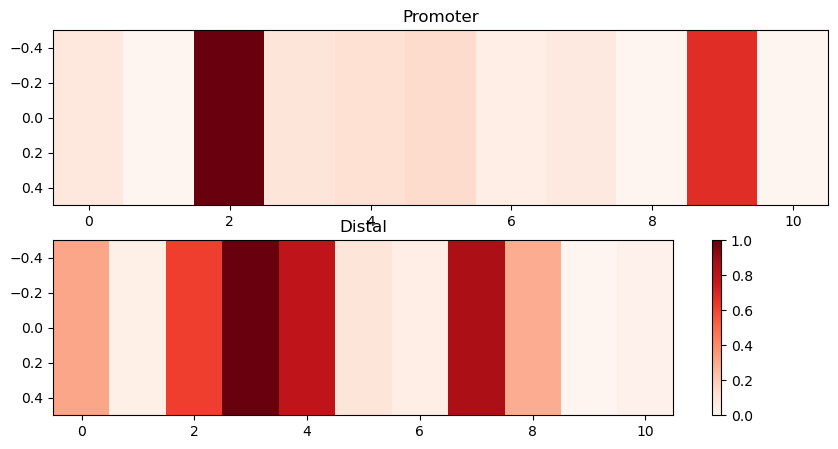

In [38]:
# Create a figure and axis
fig, ax = plt.subplots(nrows=2,figsize=(10,5))

# Plot the 1D heatmap
heatmap = ax[0].imshow([Sman_promoter.mean_min_max.tolist()], cmap='Reds', aspect='auto',vmin=0,vmax=1)
heatmap2 = ax[1].imshow([distal_peak.mean_min_max.tolist()], cmap='Reds', aspect='auto',vmin=0,vmax=1)

# Add a colorbar to show the scale
cbar = plt.colorbar(heatmap)

# Customize labels and title
ax[0].set_title('Promoter')
ax[1].set_title('Distal')

# Show the plot
plt.savefig("./Plots/Fig4/Panel4b_Sman.svg",format='svg')
plt.show()

### H. vulgaris POU4

In [63]:
ref = pyfaidx.Fasta('./Refs/HVAEP/HVAEP.genome.fa')

In [64]:
with keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll, 'tf':tf}):
    model_g = keras.models.load_model("./ChromBPNet/chrombpnet_models/Hv/fold_1/PN_nGreen_chrombpnet_nobias.h5")

In [65]:
INPUT_LEN = model_g.input_shape[1]
OUT_LEN = model_g.output_shape[0][1]

INPUT_LEN, OUT_LEN

(2114, 1000)

In [66]:
## Load in macrostoma POU4 peaks 
#peak_list = ['chr-12:57311255-57311495','chr-12:57312726-57313713','chr-12:57313821-57314190',
             #'chr-12:57314440-57315004','chr-12:57315792-57316010','chr-12:57317922-57318621']

peak_list = ['chr-12:57312726-57313713','chr-12:57313821-57314190',
             'chr-12:57314440-57315004','chr-12:57317922-57318621']
hydra_POU4_peaks = pd.DataFrame(peak_list)

hydra_POU4_peaks.columns = ['hydra_peak']
hydra_POU4_peaks[['chr', 'start']] = hydra_POU4_peaks['hydra_peak'].str.split(':', expand=True)
hydra_POU4_peaks[['start', 'end']] = hydra_POU4_peaks['start'].str.split('-', expand=True)
hydra_POU4_peaks = hydra_POU4_peaks.drop(columns=['hydra_peak'])
hydra_POU4_peaks['start'] =hydra_POU4_peaks['start'].astype(int)
hydra_POU4_peaks['end'] = hydra_POU4_peaks['end'].astype(int)

all_peaks = pd.read_csv("./Peaks/Hv.merged_peaks.narrowPeak",sep="\t",header=None)
all_peaks = all_peaks.iloc[:,:10]
all_peaks.columns = ['chr','start','end','Peak_index','score','strand','X','Y','Z','summit']
all_peaks = all_peaks[['chr','start','end','summit']]
all_peaks['start'] = all_peaks['start']+1

peak_table = pd.merge(hydra_POU4_peaks,all_peaks,how = "left",on=["chr","start","end"])


In [67]:
sequences = []
buffer = 500
for i,x in peak_table.iterrows():
    sequence = str(ref[x['chr']][((x['start']+x['summit']) - INPUT_LEN//2):((x['start']+x['summit']) + INPUT_LEN//2)])
    if len(sequence)==2114:
        sequence = sequence[:INPUT_LEN]
        sequences.append(sequence)
    else: 
        print(i)

onehot_seq = []
for i in range(len(sequences)):
    onehot_seq.append(dna_to_one_hot(sequences[i]).reshape(1,-1,4))

onehot_seq = np.concatenate( onehot_seq, axis=0 )
print(onehot_seq.shape)

(4, 2114, 4)


In [68]:
pred = model_g.predict(onehot_seq)

/opt/conda/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


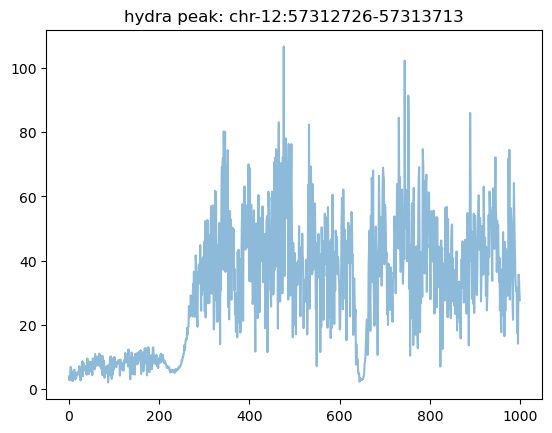

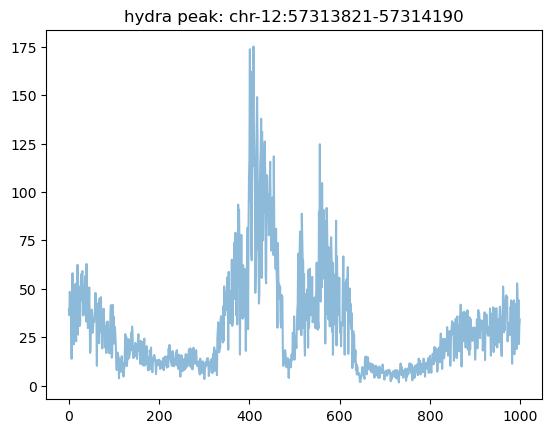

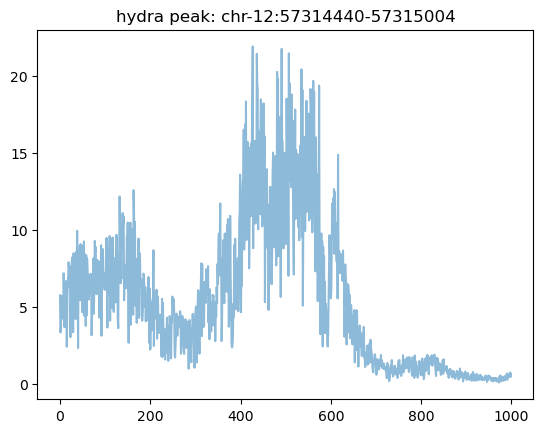

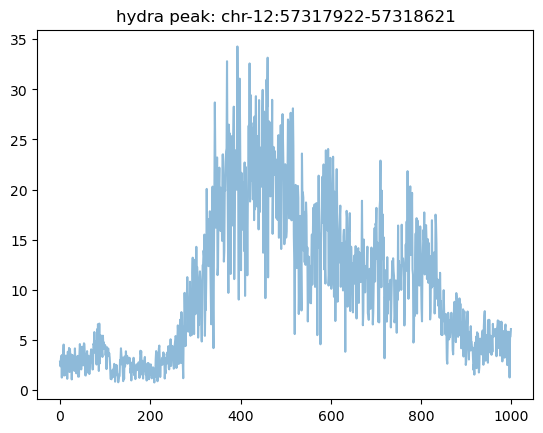

In [69]:
def plot_pred_out(preds,idx):
    logits, counts = preds
    ref_probs = softmax(logits).T
    counts_exp = np.tile(np.exp(counts),(1,1000)).T
    plt.plot((counts_exp * ref_probs)[:,idx], alpha=0.5)
    plt.title(f"hydra peak: {peak_table.iloc[idx,0]}:{peak_table.iloc[idx,1]}-{peak_table.iloc[idx,2]}")
    plt.show()
    return
    
for i in range(len(peak_table.index)):
    plot_pred_out(pred,i)



In [70]:
model_profile_explainers = shap.explainers.deep.TFDeepExplainer(
    (model_g.input, get_weightedsum_meannormed_logits(model_g)),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)
profile_shap_scores = np.array(model_profile_explainers.shap_values(
    onehot_seq, progress_message=200))
profile_scores_dict = generate_shap_dict(onehot_seq, profile_shap_scores)
project_shap_scores = np.multiply(onehot_seq,profile_shap_scores)


Done 0 examples of 4
(4, 2114, 4) (4, 2114, 4)


In [71]:
profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
    (model_g.input, tf.reduce_sum(model_g.outputs[1], axis=-1)),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)
counts_shap_scores = np.array(profile_model_counts_explainer.shap_values(
    onehot_seq, progress_message=100))
print(counts_shap_scores.shape)
counts_scores_dict = generate_shap_dict(onehot_seq, counts_shap_scores)
counts_shap_scores = np.multiply(onehot_seq,counts_shap_scores)


Done 0 examples of 4
(4, 2114, 4)
(4, 2114, 4) (4, 2114, 4)


In [72]:
### Let's add motif instance within this peak region 
neural = pd.read_csv('./Motif_filtration/Hv/PN_nGreen_mean_filtered.tsv',sep="\t")
neural['peak'] = neural['peak_chrom'] + ':' + (neural['peak_start']+1).astype(str) + '-' + neural['peak_end'].astype(str)

In [73]:
promoter1 = ['chr-12:57312726-57313713'] 
promoter2 = ['chr-12:57313821-57314190']
promoter3 = ['chr-12:57314440-57315004']
distal = ['chr-12:57317922-57318621']
promoter1 = neural[neural.peak.isin(promoter1)]
promoter2 = neural[neural.peak.isin(promoter2)]
promoter3 = neural[neural.peak.isin(promoter3)]
distal = neural[neural.peak.isin(distal)] 

# peak 1 
promoter1_index = [212739,212736,212741,212737,212728,212729]
promoter1 = promoter1[promoter1.index.isin(promoter1_index)]
promoter1 = promoter1[['key','motif_rel_start_new','motif_rel_end_new','motif_sum','motif_mean']].sort_values(by='motif_rel_start_new')
manual_add = pd.DataFrame({'key': ['JC_0255','JC_0033'],
           'motif_rel_start_new': [1007,1425],
           'motif_rel_end_new': [1021,1434],
           'motif_sum': [np.sum(counts_scores_dict["projected_shap"]["seq"][0][:,1007:1021]),
                         np.sum(counts_scores_dict["projected_shap"]["seq"][0][:,1425:1434])],
           'motif_mean': [np.mean(counts_scores_dict["projected_shap"]["seq"][0][:,1007:1021]),
                          np.mean(counts_scores_dict["projected_shap"]["seq"][0][:,1425:1434])]})

promoter1 = pd.concat([promoter1,manual_add],axis=0).sort_values(by='motif_rel_start_new')
promoter1['mean_min_max'] = min_max_norm(promoter1['motif_mean'])
promoter1['key_unique'] = 'HV_promoter1'+'_'+promoter1['key']+'_'+promoter1['motif_rel_start_new'].astype(str)


## peak 2 
promoter2_index = [109324,109327,109326,109331,109330,109325,109339]
promoter2 = promoter2[promoter2.index.isin(promoter2_index)]
promoter2 = promoter2[['key','motif_rel_start_new','motif_rel_end_new','motif_sum','motif_mean']].sort_values(by='motif_rel_start_new')
manual_add = pd.DataFrame({'key': ['ASCL1','POU4'],
           'motif_rel_start_new': [1089,1461],
           'motif_rel_end_new': [1096,1474],
           'motif_sum': [np.sum(counts_scores_dict["projected_shap"]["seq"][1][:,1089:1096]),
                         np.sum(counts_scores_dict["projected_shap"]["seq"][1][:,1461:1474])],
           'motif_mean': [np.mean(counts_scores_dict["projected_shap"]["seq"][1][:,1089:1096]),
                          np.mean(counts_scores_dict["projected_shap"]["seq"][1][:,1461:1474])]})

promoter2 = pd.concat([promoter2,manual_add],axis=0).sort_values(by='motif_rel_start_new')
promoter2['mean_min_max'] = min_max_norm(promoter2['motif_mean'])
promoter2['key_unique'] = 'HV_promoter2'+'_'+promoter2['key']+'_'+promoter2['motif_rel_start_new'].astype(str)


## peak 3 
promoter3_index = [57701,57702,57704,57707,57699]
promoter3 = promoter3[promoter3.index.isin(promoter3_index)]
promoter3 = promoter3[['key','motif_rel_start_new','motif_rel_end_new','motif_sum','motif_mean']].sort_values(by='motif_rel_start_new')
manual_add = pd.DataFrame({'key': ['POU4'],
           'motif_rel_start_new': [1019],
           'motif_rel_end_new': [1033],
           'motif_sum': [np.sum(counts_scores_dict["projected_shap"]["seq"][2][:,1019:1033])],
           'motif_mean': [np.mean(counts_scores_dict["projected_shap"]["seq"][2][:,1019:1033])]})

promoter3 = pd.concat([promoter3,manual_add],axis=0).sort_values(by='motif_rel_start_new')
promoter3['mean_min_max'] = min_max_norm(promoter3['motif_mean'])
promoter3['key_unique'] = 'HV_promoter3'+'_'+promoter3['key']+'_'+promoter3['motif_rel_start_new'].astype(str)

## peak 4 
distal_index = [248003,247987,248005,247990,248000,247986,248002,247999,248001,248006,247998]
distal = distal[distal.index.isin(distal_index)]
distal = distal[['key','motif_rel_start_new','motif_rel_end_new','motif_sum','motif_mean']].sort_values(by='motif_rel_start_new')

distal['mean_min_max'] = min_max_norm(distal['motif_mean'])
distal['key_unique'] = 'HV_distal'+'_'+distal['key']+'_'+distal['motif_rel_start_new'].astype(str)


In [74]:
promoter1

,key,motif_rel_start_new,motif_rel_end_new,motif_sum,motif_mean,mean_min_max,key_unique
0,JC_0255,1007,1021,0.255128,0.004556,0.249084,HV_promoter1_JC_0255_1007
212739,JC_0182|ZIC4(0.145),1063,1076,0.595703,0.011459,1.000000,HV_promoter1_JC_0182|ZIC4(0.145)_1063
212736,JC_0121|HAP1(0.234),1188,1194,0.057617,0.002401,0.014730,HV_promoter1_JC_0121|HAP1(0.234)_1188
212741,JC_0378|SOX18(0.038),1346,1352,0.066406,0.002766,0.054357,HV_promoter1_JC_0378|SOX18(0.038)_1346
1,JC_0033,1425,1434,0.200427,0.005567,0.359113,HV_promoter1_JC_0033_1425
212737,JC_0133|MET28(0.181),1554,1561,0.065430,0.002337,0.007676,HV_promoter1_JC_0133|MET28(0.181)_1554
212728,JC_0035|CST6(0.245),1562,1568,0.231567,0.009651,0.803320,HV_promoter1_JC_0035|CST6(0.245)_1562
212729,JC_0047|Dlx2(0.053),1677,1682,0.045319,0.002266,0.000000,HV_promoter1_JC_0047|Dlx2(0.053)_1677


In [75]:
promoter2

,key,motif_rel_start_new,motif_rel_end_new,motif_sum,motif_mean,mean_min_max,key_unique
109324,JC_0123|NFYA(0.170),999,1008,0.111938,0.003109,0.048635,HV_promoter2_JC_0123|NFYA(0.170)_999
109327,JC_0148|RGT1(0.305),1021,1028,0.065918,0.002354,0.017036,HV_promoter2_JC_0148|RGT1(0.305)_1021
109326,JC_0140|PDR1(0.111),1033,1040,0.178833,0.006390,0.185882,HV_promoter2_JC_0140|PDR1(0.111)_1033
109331,JC_0410|ZBTB14(0.000),1039,1050,0.214355,0.004871,0.122365,HV_promoter2_JC_0410|ZBTB14(0.000)_1039
109330,JC_0303|PHYPADRAFT_140773(0.030),1058,1062,0.037048,0.002316,0.015440,HV_promoter2_JC_0303|PHYPADRAFT_140773(0.030)_...
0,ASCL1,1089,1096,0.723790,0.025850,1.000000,HV_promoter2_ASCL1_1089
109325,JC_0131|CMTA2(0.171),1160,1164,0.123474,0.007717,0.241419,HV_promoter2_JC_0131|CMTA2(0.171)_1160
109339,WC_0912|DOF2.4(0.430),1197,1201,0.031143,0.001946,0.000000,HV_promoter2_WC_0912|DOF2.4(0.430)_1197
1,POU4,1461,1474,0.262601,0.005050,0.129839,HV_promoter2_POU4_1461


In [76]:
promoter3

,key,motif_rel_start_new,motif_rel_end_new,motif_sum,motif_mean,mean_min_max,key_unique
57701,JC_0142|PHO2(0.396),636,642,0.141113,0.005878,0.708225,HV_promoter3_JC_0142|PHO2(0.396)_636
57702,WC_0007|Ahr--Arnt(0.458),919,923,0.044128,0.002758,0.099367,HV_promoter3_WC_0007|Ahr--Arnt(0.458)_919
57704,WC_0275|WRKY48(0.943),1003,1007,0.041260,0.002579,0.064384,HV_promoter3_WC_0275|WRKY48(0.943)_1003
0,POU4,1019,1033,0.165130,0.002949,0.136581,HV_promoter3_POU4_1019
57707,WC_1376|PHYPADRAFT_72483(1.233),1038,1049,0.098938,0.002249,0.000000,HV_promoter3_WC_1376|PHYPADRAFT_72483(1.233)_1038
57699,JC_0096|Foxn1(0.350),1056,1060,0.117981,0.007374,1.000000,HV_promoter3_JC_0096|Foxn1(0.350)_1056


In [77]:
distal

,key,motif_rel_start_new,motif_rel_end_new,motif_sum,motif_mean,mean_min_max,key_unique
248003,JC_0303|PHYPADRAFT_140773(0.030),918,922,0.034790,0.002174,0.021112,HV_distal_JC_0303|PHYPADRAFT_140773(0.030)_918
247987,JC_0019|ZNF384(0.534),938,943,0.039764,0.001987,0.000000,HV_distal_JC_0019|ZNF384(0.534)_938
248005,JC_0303|PHYPADRAFT_140773(0.030),963,967,0.042572,0.002661,0.076045,HV_distal_JC_0303|PHYPADRAFT_140773(0.030)_963
247990,JC_0047|Dlx2(0.053),1047,1052,0.216797,0.010841,1.000000,HV_distal_JC_0047|Dlx2(0.053)_1047
248000,JC_0101|AZF1(0.282),1063,1071,0.109863,0.003433,0.163292,HV_distal_JC_0101|AZF1(0.282)_1063
247986,JC_0009|PBF(0.050),1076,1080,0.037994,0.002375,0.043731,HV_distal_JC_0009|PBF(0.050)_1076
248002,JC_0224|RAP2-3(0.191),1112,1118,0.091492,0.003811,0.205946,HV_distal_JC_0224|RAP2-3(0.191)_1112
247999,JC_0096|Foxn1(0.350),1127,1131,0.036652,0.002291,0.034252,HV_distal_JC_0096|Foxn1(0.350)_1127
248001,JC_0176|FOXC2(0.237),1308,1317,0.223877,0.006218,0.477811,HV_distal_JC_0176|FOXC2(0.237)_1308
248006,JC_0303|PHYPADRAFT_140773(0.030),1338,1342,0.050537,0.003159,0.132271,HV_distal_JC_0303|PHYPADRAFT_140773(0.030)_1338


In [69]:
# Dictionary to store the results
distal_result = {}

# Loop through the DataFrame
for index, row in distal.iterrows():
    key = row['key_unique']
    start = row['motif_rel_start_new']
    end = row['motif_rel_end_new']
    
    # Slice the array
    distal_result[key] = counts_scores_dict["projected_shap"]["seq"][3][:,start:end]

# Print the result
for key, value in distal_result.items():
    print(f"{key}: {value}")

with open('./ChromBPNet/POU4_locus/HV_distal_counts_SHAP.pkl', 'wb') as f:
    pickle.dump(distal_result, f)

HV_distal_JC_0303|PHYPADRAFT_140773(0.030)_918: [[ 0.00452097  0.00286528  0.         -0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.00636522 -0.00424667]
 [-0.          0.         -0.         -0.        ]]
HV_distal_JC_0019|ZNF384(0.534)_938: [[ 0.00287128  0.00963187  0.01297466  0.0068286   0.00771449]
 [ 0.         -0.          0.          0.          0.        ]
 [-0.         -0.          0.         -0.          0.        ]
 [ 0.         -0.         -0.         -0.         -0.        ]]
HV_distal_JC_0303|PHYPADRAFT_140773(0.030)_963: [[ 0.01174775  0.01319459  0.          0.00282818]
 [ 0.          0.          0.          0.        ]
 [-0.          0.          0.01127636  0.        ]
 [-0.          0.         -0.          0.        ]]
HV_distal_JC_0047|Dlx2(0.053)_1047: [[ 0.04622702 -0.          0.          0.03025133 -0.01333689]
 [-0.         -0.         -0.         -0.         -0.        ]
 [-0.         -0.         -0.         -0. 

/tmp/ipykernel_5598/3854571769.py:12: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)


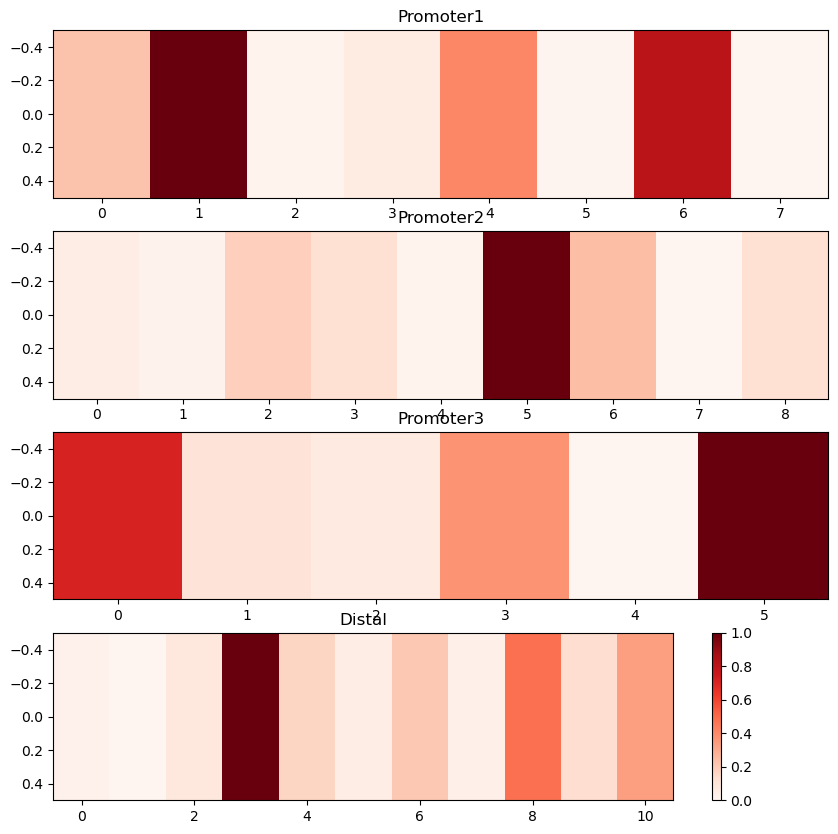

In [117]:
# Create a figure and axis
fig, ax = plt.subplots(nrows=4,figsize=(10,10))

# Plot the 1D heatmap
heatmap = ax[0].imshow([promoter1.mean_min_max.tolist()], cmap='Reds', aspect='auto',vmin=0,vmax=1)
heatmap2 = ax[1].imshow([promoter2.mean_min_max.tolist()], cmap='Reds', aspect='auto',vmin=0,vmax=1)
heatmap3 = ax[2].imshow([promoter3.mean_min_max.tolist()], cmap='Reds', aspect='auto',vmin=0,vmax=1)
heatmap4 = ax[3].imshow([distal.mean_min_max.tolist()], cmap='Reds', aspect='auto',vmin=0,vmax=1)


# Add a colorbar to show the scale
cbar = plt.colorbar(heatmap)

# Customize labels and title
ax[0].set_title('Promoter1')
ax[1].set_title('Promoter2')
ax[2].set_title('Promoter3')
ax[3].set_title('Distal')

# Show the plot
plt.savefig("./Plots/Fig4/Panel4b_Hv.svg",format='svg')
plt.show()

## Clustering to annotate as motif family label

In [54]:
### Let's load all the pickle file
import pickle
with open('./ChromBPNet/POU4_locus/Mlig_promoter_counts_SHAP.pkl', 'rb') as f:
    Mlig_promoter= pickle.load(f)

with open('./ChromBPNet/POU4_locus/Mlig_distal_counts_SHAP.pkl', 'rb') as f:
    Mlig_distal= pickle.load(f)

with open('./ChromBPNet/POU4_locus/Smed_POU1_promoter_counts_SHAP.pkl', 'rb') as f:
    Smed_POU1_promoter= pickle.load(f)

with open('./ChromBPNet/POU4_locus/Smed_POU1_distal_counts_SHAP.pkl', 'rb') as f:
    Smed_POU1_distal= pickle.load(f)

with open('./ChromBPNet/POU4_locus/Smed_POU2_promoter_counts_SHAP.pkl', 'rb') as f:
    Smed_POU2_promoter= pickle.load(f)

with open('./ChromBPNet/POU4_locus/Smed_POU2_distal_counts_SHAP.pkl', 'rb') as f:
    Smed_POU2_distal= pickle.load(f)

with open('./ChromBPNet/POU4_locus/Sman_promoter_counts_SHAP.pkl', 'rb') as f:
    Sman_promoter= pickle.load(f)

with open('./ChromBPNet/POU4_locus/Sman_distal_counts_SHAP.pkl', 'rb') as f:
    Sman_distal= pickle.load(f)

with open('./ChromBPNet/POU4_locus/HV_promoter1_counts_SHAP.pkl', 'rb') as f:
    HV_promoter1= pickle.load(f)

with open('./ChromBPNet/POU4_locus/HV_promoter2_counts_SHAP.pkl', 'rb') as f:
    HV_promoter2= pickle.load(f)

with open('./ChromBPNet/POU4_locus/HV_promoter3_counts_SHAP.pkl', 'rb') as f:
    HV_promoter3= pickle.load(f)

with open('./ChromBPNet/POU4_locus/HV_distal_counts_SHAP.pkl', 'rb') as f:
    HV_distal= pickle.load(f)

Mlig_promoter_rms = 0.0072170039756451095
Mlig_distal_rms = 0.00567382731033522

Smed_POU1_promoter_rms = 0.0026181802260306585
Smed_POU1_distal_rms = 0.0018311873888384167

Smed_POU2_promoter_rms = 0.002926696860122646
Smed_POU2_distal_rms = 0.0018753580674789156

Sman_promoter_rms = 0.002823321682916212
Sman_distal_rms = 0.0021387219787925744

HV_promoter1_rms = 0.007531876029663295
HV_promoter2_rms = 0.009760861836560535
HV_promoter3_rms = 0.0053702005712930505
HV_distal_rms = 0.006292618697873056

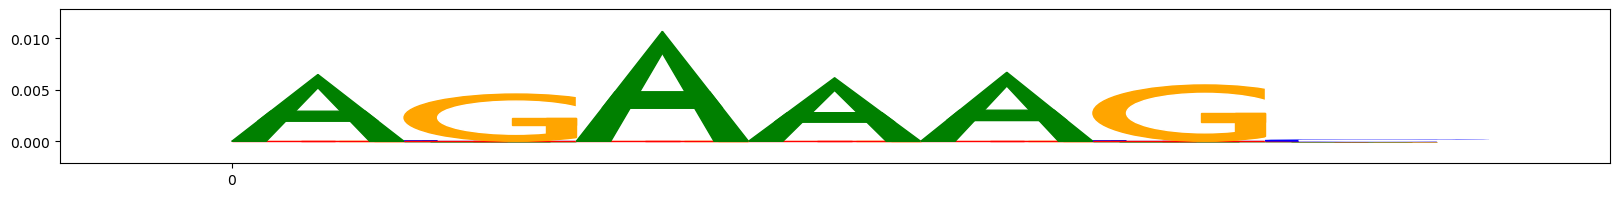

In [55]:
plot_weights(Sman_distal['Sman_distal_JC_0418_1409'], subticks_frequency=100)

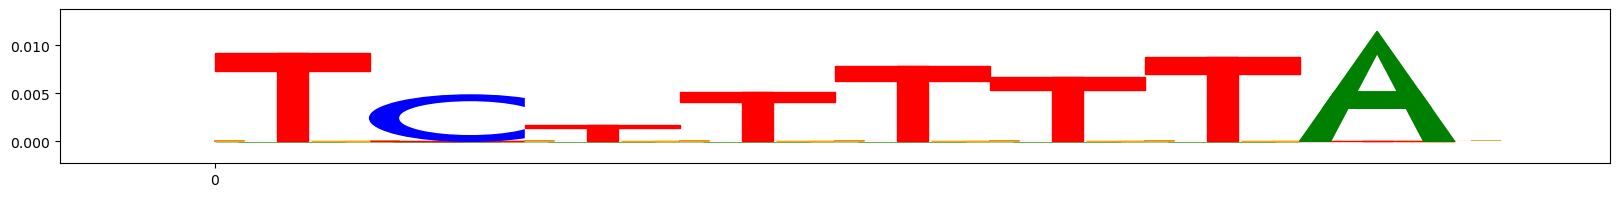

In [56]:
plot_weights(HV_distal['HV_distal_JC_0101|AZF1(0.282)_1063'], subticks_frequency=100)

In [57]:
Mlig_promoter_test = {key: np.array([x / Mlig_promoter_rms for x in value]).T for key, value in Mlig_promoter.items()}
Mlig_distal_test = {key: np.array([x / Mlig_distal_rms for x in value]).T for key, value in Mlig_distal.items()}

Smed_POU1_promoter_test = {key: np.array([x / Smed_POU1_promoter_rms for x in value]).T for key, value in Smed_POU1_promoter.items()}
Smed_POU1_distal_test = {key: np.array([x / Smed_POU1_distal_rms for x in value]).T for key, value in Smed_POU1_distal.items()}

Smed_POU2_promoter_test = {key: np.array([x / Smed_POU2_promoter_rms for x in value]).T for key, value in Smed_POU2_promoter.items()}
Smed_POU2_distal_test = {key: np.array([x / Smed_POU2_distal_rms for x in value]).T for key, value in Smed_POU2_distal.items()}

Sman_promoter_test = {key: np.array([x / Sman_promoter_rms for x in value]).T for key, value in Sman_promoter.items()}
Sman_distal_test = {key: np.array([x / Sman_distal_rms for x in value]).T for key, value in Sman_distal.items()}

HV_promoter1_test = {key: np.array([x / HV_promoter1_rms for x in value]).T for key, value in HV_promoter1.items()}
HV_promoter2_test = {key: np.array([x / HV_promoter2_rms for x in value]).T for key, value in HV_promoter2.items()}
HV_promoter3_test = {key: np.array([x / HV_promoter3_rms for x in value]).T for key, value in HV_promoter3.items()}
HV_distal_test = {key: np.array([x / HV_distal_rms for x in value]).T for key, value in HV_distal.items()}


merged_dict = {**Mlig_promoter_test, **Mlig_distal_test,
               **Smed_POU1_promoter_test, **Smed_POU1_distal_test,
               **Smed_POU2_promoter_test, **Smed_POU2_distal_test,
               **Sman_promoter_test, **Sman_distal_test,
               **HV_promoter1_test, **HV_promoter2_test, **HV_promoter3_test, **HV_distal_test}

In [58]:
keys = list(merged_dict.keys())

In [59]:
# Extract keys and arrays
keys = list(merged_dict.keys())
arrays = list(merged_dict.values())

# Create an empty DataFrame to store the similarity scores
similarity_df = pd.DataFrame(index=keys, columns=keys)

# Compute similarity scores
for i, key_i in enumerate(keys):
    for j, key_j in enumerate(keys):
        if i <= j:  # Compute only for upper triangle and diagonal
            score = getSHAPSimilarity(arrays[i], arrays[j])
            similarity_df.at[key_i, key_j] = score[0]
            similarity_df.at[key_j, key_i] = score[0]  # Symmetric score

#np.fill_diagonal(similarity_df.values, 0)
print(similarity_df)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


                                                Mlig_promoter_JC_0123_851  \
Mlig_promoter_JC_0123_851                                       16.665747   
Mlig_promoter_JC_0094_874                                        4.215291   
Mlig_promoter_JC_0118_898                                        3.218545   
Mlig_promoter_JC_0398_933                                         8.55154   
Mlig_promoter_JC_0318_968                                       10.506536   
...                                                                   ...   
HV_distal_JC_0224|RAP2-3(0.191)_1112                             6.201854   
HV_distal_JC_0096|Foxn1(0.350)_1127                              6.806791   
HV_distal_JC_0176|FOXC2(0.237)_1308                              9.155416   
HV_distal_JC_0303|PHYPADRAFT_140773(0.030)_1338                  5.349624   
HV_distal_JC_0096|Foxn1(0.350)_1414                              7.018112   

                                                Mlig_promoter_JC_0094_874  

(array([7.691e+03, 1.222e+03, 3.930e+02, 2.070e+02, 1.120e+02, 6.200e+01,
        2.500e+01, 1.400e+01, 1.900e+01, 1.000e+01, 1.400e+01, 5.000e+00,
        8.000e+00, 4.000e+00, 2.000e+00, 4.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.0, 7.723203803451623, 15.446407606903247, 23.169611410354868,
        30.892815213806493, 38.61601901725812, 46.339222820709736,
        54.06242662416136, 61.785630427612986, 69.50883423106461,
        77.23203803451624, 84.95524183796786, 92.67844564141947,
        100.4016494448711, 108.12485324832272, 115.84805705177435,
        123.57126085522597, 131.2944646

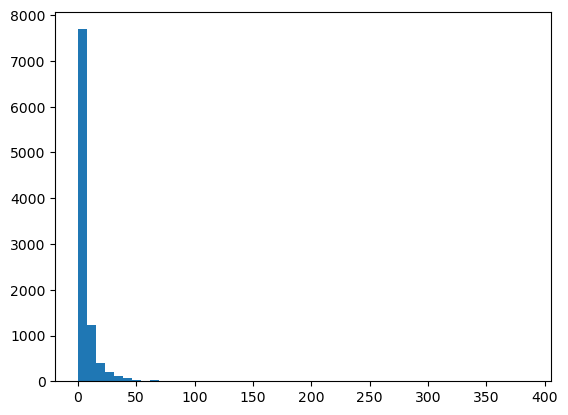

In [60]:
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
import seaborn as sns
from scipy.spatial.distance import squareform

plt.hist( similarity_df.values.flatten(), bins=50 )


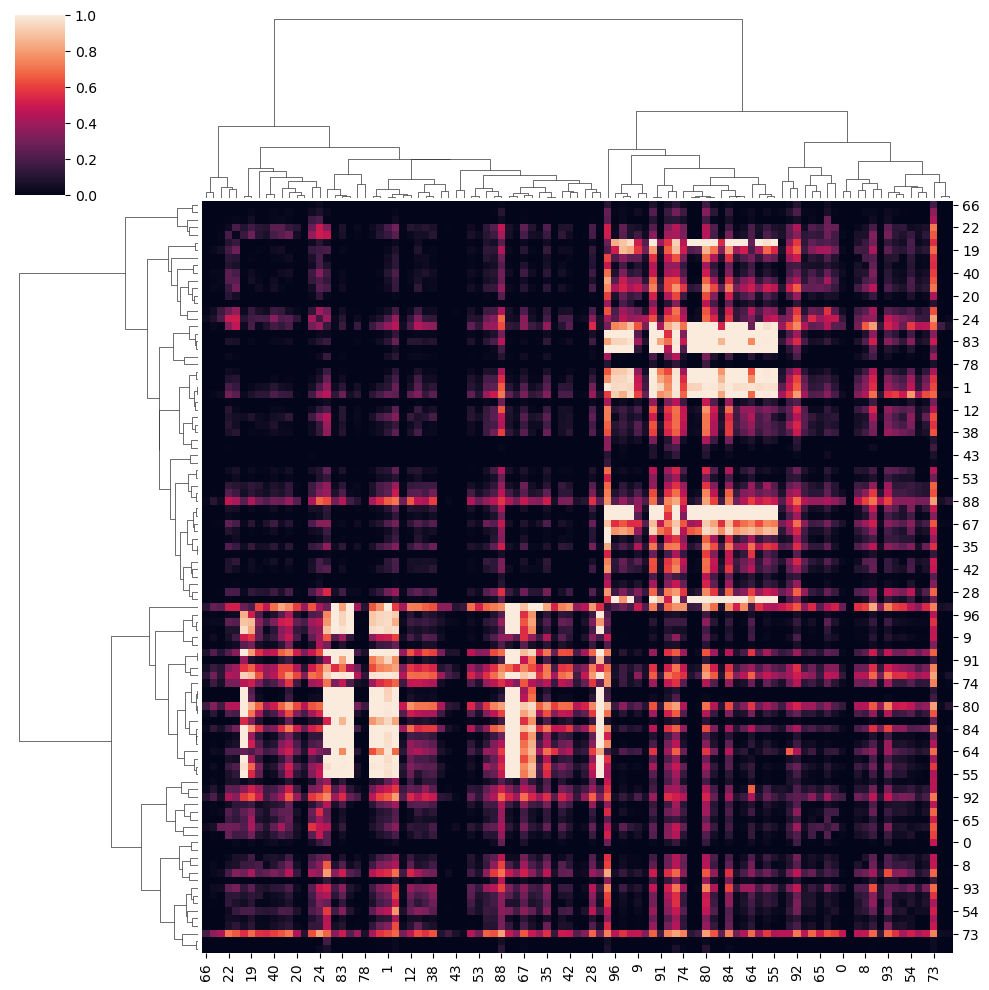

In [61]:
Z = linkage( similarity_df.values, method='complete', metric='correlation' )
t = sns.clustermap( np.exp(-similarity_df.values.astype(float)), col_linkage=Z, row_linkage=Z )


In [63]:
similarity_df.iloc[t.dendrogram_row.reordered_ind,t.dendrogram_row.reordered_ind]

,HV_promoter1_JC_0182|ZIC4(0.145)_1063,HV_promoter1_JC_0033_1425,Sman_promoter_WC_1517_1206,Smed_promoter_POU1_JC_0030_1012,HV_promoter3_WC_1376|PHYPADRAFT_72483(1.233)_1038,Mlig_distal_JC_0028_991,Mlig_distal_JC_0028_1223,HV_promoter2_JC_0410|ZBTB14(0.000)_1039,Mlig_distal_JC_0211_1087,Smed_distal_POU2_JC_0352_1092,...,Sman_promoter_WC_0968_1195,HV_distal_JC_0009|PBF(0.050)_1076,HV_distal_JC_0303|PHYPADRAFT_140773(0.030)_963,HV_distal_JC_0303|PHYPADRAFT_140773(0.030)_1338,Sman_distal_JC_0038_855,Sman_distal_JC_0416_1218,Sman_distal_JC_0000_1335,HV_promoter2_JC_0123|NFYA(0.170)_999,Smed_promoter_POU1_JC_0080_1074,Smed_promoter_POU2_JC_0080_1151
HV_promoter1_JC_0182|ZIC4(0.145)_1063,52.797375,34.557838,19.398849,7.563799,8.009081,11.870523,7.426681,12.440014,10.194775,5.517268,...,28.115649,6.971257,10.01197,11.503034,9.904115,14.55934,13.965709,1.713596,45.82998,37.730025
HV_promoter1_JC_0033_1425,34.557838,22.279642,16.250214,6.302994,6.363234,6.078843,3.784745,7.626986,5.508618,4.12145,...,14.604946,3.366286,3.923126,4.711967,5.269362,7.415015,7.035838,1.042532,22.64458,19.891602
Sman_promoter_WC_1517_1206,19.398849,16.250214,13.978945,4.703087,4.153459,4.536615,3.008263,7.8222,6.210861,4.144224,...,10.823181,3.140981,6.506929,8.391664,6.110369,9.484949,10.809048,0.847304,21.959786,18.021512
Smed_promoter_POU1_JC_0030_1012,7.563799,6.302994,4.703087,3.406602,1.656043,2.351107,1.746268,2.163954,2.326701,1.462681,...,4.847102,1.387649,2.204207,2.087324,3.15692,3.004253,2.677514,0.338852,10.459414,6.885871
HV_promoter3_WC_1376|PHYPADRAFT_72483(1.233)_1038,8.009081,6.363234,4.153459,1.656043,3.909105,1.930783,1.29609,2.300388,2.666937,1.692992,...,4.432712,1.225426,2.113521,2.552963,1.924342,3.098187,2.138686,0.427783,8.460147,7.515091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sman_distal_JC_0416_1218,14.55934,7.415015,9.484949,3.004253,3.098187,3.654744,2.581398,4.131988,4.369153,3.438857,...,9.916378,2.16423,3.626597,3.452224,3.112229,9.69937,5.893978,0.884041,16.868372,14.782637
Sman_distal_JC_0000_1335,13.965709,7.035838,10.809048,2.677514,2.138686,2.848001,2.167256,3.89542,3.782943,2.899976,...,5.303309,1.210919,2.666785,2.473145,3.108936,5.893978,5.736292,0.718126,12.205795,9.0321
HV_promoter2_JC_0123|NFYA(0.170)_999,1.713596,1.042532,0.847304,0.338852,0.427783,0.584929,0.378622,0.570996,0.599668,0.517137,...,1.980054,0.370997,0.565171,0.864922,0.664954,0.884041,0.718126,0.307626,3.29969,3.40828
Smed_promoter_POU1_JC_0080_1074,45.82998,22.64458,21.959786,10.459414,8.460147,6.960223,5.044364,9.503491,10.577899,8.906779,...,33.419963,7.296048,8.733329,9.812464,9.181553,16.868372,12.205795,3.29969,83.064886,67.390203


In [64]:
similarity_df.head(n=56)

,Mlig_promoter_JC_0123_851,Mlig_promoter_JC_0094_874,Mlig_promoter_JC_0118_898,Mlig_promoter_JC_0398_933,Mlig_promoter_JC_0318_968,Mlig_promoter_JC_0050_1021,Mlig_promoter_JC_0094_1043,Mlig_promoter_JC_0094_1048,Mlig_promoter_JC_0142_1054,Mlig_promoter_JC_0255_1091,...,HV_distal_JC_0019|ZNF384(0.534)_938,HV_distal_JC_0303|PHYPADRAFT_140773(0.030)_963,HV_distal_JC_0047|Dlx2(0.053)_1047,HV_distal_JC_0101|AZF1(0.282)_1063,HV_distal_JC_0009|PBF(0.050)_1076,HV_distal_JC_0224|RAP2-3(0.191)_1112,HV_distal_JC_0096|Foxn1(0.350)_1127,HV_distal_JC_0176|FOXC2(0.237)_1308,HV_distal_JC_0303|PHYPADRAFT_140773(0.030)_1338,HV_distal_JC_0096|Foxn1(0.350)_1414
Mlig_promoter_JC_0123_851,16.665747,4.215291,3.218545,8.55154,10.506536,6.262381,5.053205,7.629909,7.344011,5.999369,...,3.980973,5.490521,20.982679,1.768116,2.639662,6.201854,6.806791,9.155416,5.349624,7.018112
Mlig_promoter_JC_0094_874,4.215291,2.168495,1.334724,1.437565,6.097744,3.600866,2.531872,2.525696,1.067443,0.679512,...,0.015706,1.21563,0.05694,0.416645,0.955188,3.06466,3.922752,0.051004,1.421557,3.311468
Mlig_promoter_JC_0118_898,3.218545,1.334724,1.441687,1.116857,3.949588,2.164904,1.697542,1.987426,0.829305,0.511051,...,0.0,0.52401,0.262857,0.222956,0.587003,2.056339,2.438096,0.084122,0.697896,2.058166
Mlig_promoter_JC_0398_933,8.55154,1.437565,1.116857,4.927331,3.649727,2.663081,1.710005,2.836414,2.547375,4.37617,...,1.617119,2.189575,9.364582,1.282424,1.588697,2.153243,3.829485,5.404013,2.599099,3.231617
Mlig_promoter_JC_0318_968,10.506536,6.097744,3.949588,3.649727,21.986863,10.568672,7.213891,7.446071,3.479233,2.996918,...,1.553847,3.703527,5.608577,1.530146,3.939371,7.731465,11.951375,4.205044,4.3309,10.088684
Mlig_promoter_JC_0050_1021,6.262381,3.600866,2.164904,2.663081,10.568672,8.292416,6.627056,4.07865,1.797761,1.04709,...,0.0,2.251948,0.320944,0.771833,1.749595,5.499276,7.266875,0.102712,2.633425,6.134475
Mlig_promoter_JC_0094_1043,5.053205,2.531872,1.697542,1.710005,7.213891,6.627056,5.786965,3.110117,1.174568,0.723816,...,0.0,1.44601,0.185696,0.495605,1.123441,4.378081,4.666169,0.059428,1.690962,3.939038
Mlig_promoter_JC_0094_1048,7.629909,2.525696,1.987426,2.836414,7.446071,4.07865,3.110117,4.208152,2.311061,1.518571,...,0.848709,1.466146,2.541824,0.626788,1.139085,3.369941,4.731147,2.276848,1.714509,3.99389
Mlig_promoter_JC_0142_1054,7.344011,1.067443,0.829305,2.547375,3.479233,1.797761,1.174568,2.311061,4.363031,4.383968,...,1.844012,1.95511,8.833197,1.503222,1.565069,1.598858,2.843527,6.114595,1.829761,2.400419
Mlig_promoter_JC_0255_1091,5.999369,0.679512,0.511051,4.37617,2.996918,1.04709,0.723816,1.518571,4.383968,5.914815,...,2.691454,3.222656,14.048422,1.650963,2.335654,0.985281,1.701338,6.19251,2.993614,1.479235


In [65]:
similarity_df.iloc[t.dendrogram_row.reordered_ind,t.dendrogram_row.reordered_ind].index

Index(['HV_promoter1_JC_0182|ZIC4(0.145)_1063', 'HV_promoter1_JC_0033_1425',
       'Sman_promoter_WC_1517_1206', 'Smed_promoter_POU1_JC_0030_1012',
       'HV_promoter3_WC_1376|PHYPADRAFT_72483(1.233)_1038',
       'Mlig_distal_JC_0028_991', 'Mlig_distal_JC_0028_1223',
       'HV_promoter2_JC_0410|ZBTB14(0.000)_1039', 'Mlig_distal_JC_0211_1087',
       'Smed_distal_POU2_JC_0352_1092', 'Smed_promoter_POU2_JC_0392_1098',
       'Mlig_promoter_JC_0185_1125', 'Mlig_distal_JC_0428_1243',
       'Sman_distal_JC_0407_991', 'Mlig_promoter_WC_0614_1253',
       'Smed_promoter_POU1_JC_0268_1132', 'Mlig_distal_WC_0061_1055',
       'HV_promoter2_JC_0131|CMTA2(0.171)_1160',
       'HV_promoter3_WC_0007|Ahr--Arnt(0.458)_919',
       'HV_promoter3_JC_0096|Foxn1(0.350)_1056', 'Mlig_distal_JC_0172_906',
       'HV_promoter2_ASCL1_1089', 'Mlig_promoter_JC_0050_1021',
       'Mlig_promoter_JC_0094_1043', 'Mlig_promoter_JC_0094_874',
       'Mlig_promoter_JC_0118_898', 'Mlig_promoter_JC_0318_968',
     

In [117]:
### After manual trimming the tree, we assign the cluster 
cluster_assignment = pd.DataFrame(similarity_df.index)
cluster_assignment['cluster'] = 0
cluster_assignment.columns = ['motif','cluster']

cluster_1 = ['Smed_promoter_POU1_JC_0030_1012','Sman_promoter_WC_1517_1206','HV_promoter1_JC_0182|ZIC4(0.145)_1063',
             'HV_promoter1_JC_0033_1425','HV_promoter3_WC_1376|PHYPADRAFT_72483(1.233)_1038'] #bhlh grey color

cluster_2 = ['Mlig_promoter_JC_0185_1125','Mlig_promoter_WC_0614_1253','Mlig_distal_JC_0028_991',
             'Mlig_distal_JC_0211_1087','Mlig_distal_JC_0028_1223','Mlig_distal_JC_0428_1243',
             'Smed_promoter_POU1_JC_0268_1132','Smed_promoter_POU2_JC_0392_1098','Smed_distal_POU2_JC_0352_1092',
             'Sman_distal_JC_0407_991','HV_promoter2_JC_0410|ZBTB14(0.000)_1039'] #zinc finger green 

cluster_3 = ['Mlig_promoter_JC_0398_933','Mlig_promoter_JC_0142_1054','Mlig_distal_JC_0172_906',
             'Mlig_distal_JC_0142_1040','Mlig_distal_WC_0061_1055','HV_promoter2_ASCL1_1089',
             'HV_promoter2_JC_0131|CMTA2(0.171)_1160','HV_promoter3_WC_0007|Ahr--Arnt(0.458)_919','HV_promoter3_JC_0096|Foxn1(0.350)_1056'] #homeo brown color

cluster_4 = ['Mlig_promoter_JC_0094_874','Mlig_promoter_JC_0118_898','Mlig_promoter_JC_0318_968',
             'Mlig_promoter_JC_0050_1021','Mlig_promoter_JC_0094_1043','Mlig_promoter_JC_0094_1048',
             'Smed_promoter_POU2_JC_0334_1141','Smed_distal_POU2_JC_0108_1070','Smed_distal_POU2_JC_0115_1083',
             'Sman_distal_WC_0470_1193'] #zinc finger dark pink

cluster_5 = ['Smed_promoter_POU1_WC_0968_1166','Smed_promoter_POU2_JC_0316_920','Smed_promoter_POU2_JC_0075_1246',
             'Smed_distal_POU2_JC_0075_994','Smed_distal_POU2_JC_0096_1010','Smed_distal_POU2_JC_0200_1226',
             'Smed_distal_POU2_JC_0316_1325','Sman_promoter_WC_0853_1053','Sman_promoter_WC_0943_1330',
             'Sman_promoter_JC_0172_1346','Sman_distal_JC_0084_1376','HV_promoter1_JC_0121|HAP1(0.234)_1188',
             'HV_promoter1_JC_0378|SOX18(0.038)_1346','HV_promoter1_JC_0035|CST6(0.245)_1562','HV_promoter2_JC_0140|PDR1(0.111)_1033',
             'HV_promoter2_JC_0303|PHYPADRAFT_140773(0.030)_1058','HV_distal_JC_0224|RAP2-3(0.191)_1112','HV_distal_JC_0096|Foxn1(0.350)_1127',
             'HV_distal_JC_0096|Foxn1(0.350)_1414'] # FOX-like purple

cluster_6 = ['Mlig_promoter_JC_0255_1091','Mlig_promoter_JC_0255_1109','Smed_distal_POU1_JC_0255_1256',
             'Sman_promoter_JC_0303_1155','HV_promoter1_JC_0255_1007','HV_promoter2_POU4_1461',
             'HV_promoter3_POU4_1019','HV_distal_JC_0176|FOXC2(0.237)_1308'] # POU4-like peach

cluster_7 = ['Smed_promoter_POU1_JC_0047_1003', 'Smed_distal_POU1_JC_0047_994','Smed_promoter_POU2_JC_0047_953',
             'Sman_promoter_JC_0303_1094', 'Sman_promoter_JC_0142_1143','Sman_promoter_JC_0303_1259',
             'Sman_distal_JC_0006_873','Sman_distal_JC_0019_1213','Sman_distal_JC_0019_1399',
             'Sman_distal_JC_0244_1462','HV_promoter1_JC_0047|Dlx2(0.053)_1677','HV_promoter2_JC_0148|RGT1(0.305)_1021',
             'HV_promoter2_WC_0912|DOF2.4(0.430)_1197','HV_promoter3_JC_0142|PHO2(0.396)_636','HV_promoter3_WC_0275|WRKY48(0.943)_1003',
             'HV_distal_JC_0019|ZNF384(0.534)_938','HV_distal_JC_0047|Dlx2(0.053)_1047'] # DLX-like light blue 

cluster_8 = ['Mlig_distal_JC_0142_1040','Smed_promoter_POU2_WC_0747_1118','Sman_promoter_JC_0216_1132',
             'Sman_distal_JC_0418_1409','HV_promoter1_JC_0133|MET28(0.181)_1554','HV_distal_JC_0101|AZF1(0.282)_1063'] # zinc-finger lime green


cluster_9 = ['Mlig_promoter_JC_0123_851','Smed_promoter_POU1_JC_0080_1074','Smed_promoter_POU2_JC_0080_1151',
             'Smed_promoter_POU2_WC_0968_1207','Sman_promoter_JC_0123_1108','Sman_promoter_WC_0968_1195',
             'Sman_distal_JC_0038_855','Sman_distal_JC_0416_1218','Sman_distal_JC_0000_1335',
             'HV_promoter2_JC_0123|NFYA(0.170)_999','HV_distal_JC_0303|PHYPADRAFT_140773(0.030)_918','HV_distal_JC_0303|PHYPADRAFT_140773(0.030)_963',
             'HV_distal_JC_0009|PBF(0.050)_1076','HV_distal_JC_0303|PHYPADRAFT_140773(0.030)_1338'] # NFY-like dark blue

cluster_assignment.loc[cluster_assignment['motif'].isin(cluster_1), 'cluster'] = 'bhlh'
cluster_assignment.loc[cluster_assignment['motif'].isin(cluster_2), 'cluster'] = 'zinc_finger_darkgreen'
cluster_assignment.loc[cluster_assignment['motif'].isin(cluster_3), 'cluster'] = 'homeo'
cluster_assignment.loc[cluster_assignment['motif'].isin(cluster_4), 'cluster'] = 'zinc_finger_pink'
cluster_assignment.loc[cluster_assignment['motif'].isin(cluster_5), 'cluster'] = 'FOX-like'
cluster_assignment.loc[cluster_assignment['motif'].isin(cluster_6), 'cluster'] = 'POU4-like'
cluster_assignment.loc[cluster_assignment['motif'].isin(cluster_7), 'cluster'] = 'DLX-like'
cluster_assignment.loc[cluster_assignment['motif'].isin(cluster_8), 'cluster'] = 'zinc_finger_limegreen'
cluster_assignment.loc[cluster_assignment['motif'].isin(cluster_9), 'cluster'] = 'NFY-like'

In [119]:
cluster_assignment.to_csv("./ChromBPNet/POU4_locus/POU4_locus_cluster_assigment.tsv", sep="\t",index=False)